In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


# Техническая часть

## Удаление горячих пикселей

In [ ]:
data = pd.read_excel('../data/df_raw.xlsx', index_col=[0, 1, 2, 3])
data = data.groupby(level=['IDcard', 'GROUP']).mean()
y = pd.Series(np.array([1 if group == 'Parkinson' else 0 for group in data.index.get_level_values(level="GROUP")]))
# y = pd.Series([1 if x == "Parkinson" else 0 for x in data.index.get_level_values("GROUP").to_list()], index = data.index)

In [2]:
def delete_hot_pixels(arr: list, q: float=0.9,
                      window: int = 3) -> list:
    delta = pd.Series(np.array([]))
    for i in range(1, len(arr) - 1):
        x1 = arr[i-1]
        x2 = arr[i]
        x3 = arr[i+1]
        delta[i] = (x2-x1)*(x3-x2)
    q_value = delta.quantile(1-q)
    filtered_arr = [arr[0]]
    for i in range(1, len(arr)-1):
        if delta[i] <= q_value:
            filtered_arr.append(
                sum(arr[i-window//2:i] +\
                    arr[i+1:i+window//2+1]) / (window-1)
                )
        else:
            filtered_arr.append(arr[i])
    filtered_arr.append(arr[-1])
    return filtered_arr

In [3]:
pd.set_option('display.max_columns', 20)
df = pd.read_excel("./data/data_merged_new.xlsx", index_col=0)
df.set_index("IDcard", inplace=True)

group = []
for x in df.loc["БП008(Л)":].index:
    if "БП" in x:
        group.append("Parkinson")
    else:
        group.append("Control")
group = df.dropna(subset=["GROUP"])["GROUP"].to_list() + group
df["GROUP"] = group
df.reset_index(inplace=True)
df["level_3"] =  [x + f"_{i % 8 + 1}" for i, x in enumerate(df["IDcard"])]
df.set_index(["GROUP", "IDcard", "level_3"], inplace=True)
df_1 = df.loc[:, 401.733364293274:]

df_1.rename(axis=1,
          mapper=lambda x: f"{int(x)}",
          inplace=True)

In [4]:
df_raw = df_1.copy()
df_raw = df_raw.astype("float32")
for index in df_raw.index:
    df_raw.loc[index, df_raw.columns[:-70]] = delete_hot_pixels(df_raw.loc[index, df_raw.columns[:-70]].to_list(), q=0.95, window=7)


In [15]:
from scipy.signal import savgol_filter

def smooth(data: pd.DataFrame, window_length:int=7, polyorder:int=3) -> pd.DataFrame:
    data_sm = None
    for y in data.to_numpy():
        y_smooth = savgol_filter(y, window_length, polyorder)
        if data_sm is None:
            data_sm = y_smooth
        else:
            data_sm = np.vstack((data_sm, y_smooth))
    df_sm = pd.DataFrame(data_sm, index=data.index, columns=data.columns)
    return df_sm

In [59]:
df_raw_1 = df_raw.copy()

In [16]:
df_raw_1[df_raw_1.columns[:-70]] = smooth(df_raw_1[df_raw_1.columns[:-70]], 7)

In [17]:
df_raw = df_raw_1.copy()

In [9]:
hand = ["left" if x[:-3] == "(Л)" else "right" for x in df_raw.index.get_level_values(level="IDcard")]
df_raw["hand"] = hand
df_raw.reset_index(inplace=True)
df_raw["IDcard"] = df_raw["IDcard"].apply(lambda x: x[:-3] if x[-3] == "(" else x)
df_raw.set_index(["GROUP", "IDcard", "hand", "level_3"], inplace=True)

In [10]:
df_raw.to_excel("./data/df_raw.xlsx")

In [2]:
df_raw = pd.read_excel("./data/df_raw.xlsx", index_col=[0, 1, 2, 3])

In [3]:
pd.set_option('display.max_columns', None)
df_raw.head(5)

level_3         401         403         405         407  \
GROUP   IDcard hand                                                            
Control CG1    right   CG1_1  272.182526  238.924606  254.722214  295.547607   
               right   CG1_2  250.095245  258.071442  264.214294  269.523804   
               right   CG1_3  226.452377  225.785721  228.857147  234.666672   
               right   CG1_4  214.261902  215.357147  216.714279  219.333328   
               right   CG1_5  200.880951  212.476196  216.047623  216.428574   

                             409         410         412         414  \
GROUP   IDcard hand                                                    
Control CG1    right  336.968262  332.523804  342.809509  355.809509   
               right  274.571442  282.190491  292.142853  300.285706   
               right  242.047623  249.761902  261.095245  272.095245   
               right  225.523804  232.285721  244.666672  251.047623   
               right  221.714279  230.619049  239.523804  249.523804   

                             416         418         420         421  \
GROUP   IDcard hand                                                    
Control CG1    right  364.428558  374.904755  386.571442  405.190491   
               right  310.428558  322.000000  329.904755  342.904755   
               right  280.857147  288.523804  296.238098  307.142853   
               right  258.857147  267.761902  280.761902  293.000000   
               right  257.761902  262.333344  271.142853  279.666656   

                             423         425         427         429  \
GROUP   IDcard hand                                                    
Control CG1    right  423.047607  445.142853  468.523804  494.666656   
               right  359.809509  383.571442  409.809509  434.476196   
               right  318.952393  338.428558  360.047607  380.333344   
               right  309.428558  325.523804  342.857147  359.523804   
               right  289.523804  303.047607  320.238098  340.285706   

                             431         433         434         436  \
GROUP   IDcard hand                                                    
Control CG1    right  520.571411  552.095215  583.047607  624.380981   
               right  454.428558  477.380951  495.809509  525.809509   
               right  400.000000  418.000000  434.666656  463.761902   
               right  374.476196  390.190491  410.523804  437.095245   
               right  360.190491  378.904755  398.619049  422.428558   

                             438         440         442         444  \
GROUP   IDcard hand                                                    
Control CG1    right  670.952393  725.333313  785.000000  849.380981   
               right  565.428589  614.333313  672.000000  731.571411   
               right  501.809509  542.666687  592.571411  642.238098   
               right  473.190491  513.428589  556.095215  601.809509   
               right  453.476196  492.333344  535.190491  582.285706   

                             445         447          449          451  \
GROUP   IDcard hand                                                      
Control CG1    right  921.952393  998.238098  1061.523804  1111.000000   
               right  793.000000  859.095215   920.761902   969.761902   
               right  695.333313  753.095215   811.523804   858.571411   
               right  655.095215  706.714294   758.285706   799.142883   
               right  632.619019  683.047607   732.714294   770.857117   

                              453          455          457          458  \
GROUP   IDcard hand                                                        
Control CG1    right  1142.666626  1159.142822  1177.714233  1197.238037   
               right  1002.000000  1020.142883  1038.571411  1061.857178   
               right   892.380981   908.619019   919.142883   934.714294   
               right   825.761902   

In [6]:
df_raw.set_index("level_3", append=True, inplace=True)

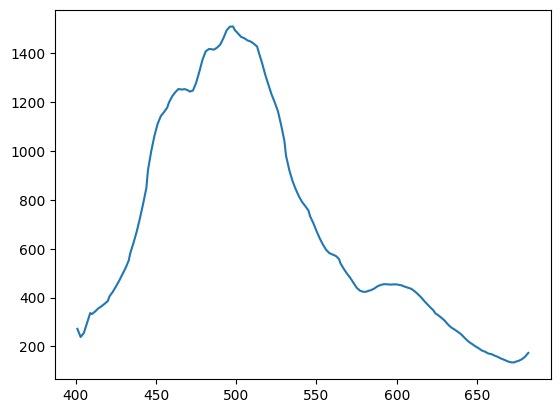

In [3]:
plt.plot(df_raw.columns[0:150].astype(int), df_raw.loc[df_raw.index[0], df_raw.columns[0:150]])

## D-нормировка

In [4]:
from typing import Union
def d_norm(data: Union[pd.Series, pd.DataFrame],
                laser_wave_left: Union[float, str] = 731.195121105382,
                laser_wave_right: Union[float, str] = 772.244519389919,
                cutoff_wave: Union[float, str] = 676.874469938485):
    if isinstance(data, pd.Series):
        data = data.loc[:cutoff_wave].div(
            data.loc[laser_wave_left:laser_wave_right].mean())
    else:
        data = data.loc[:, :cutoff_wave].div(
            data.loc[:, laser_wave_left:laser_wave_right].mean(axis=1),
            axis=0)
        data.rename(axis=1,
                    mapper=lambda x: f"D{int(x)}",
                    inplace=True)
    return data

In [13]:
df_raw.to_excel(".\\data\\df_raw.xlsx")

In [5]:
data = df_raw_1.copy()
laser_wave_left ="731"
laser_wave_right = "772"
cutoff_wave  = "676"
data = data.loc[:, :cutoff_wave].div(
    data.loc[:, laser_wave_left:laser_wave_right].sum(axis=1),
    axis=0).sum(axis=1)

NameError: name 'df_raw_1' is not defined

C:\Users\nikba\AppData\Local\Temp\ipykernel_19416\4088455624.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='Values', data=df,


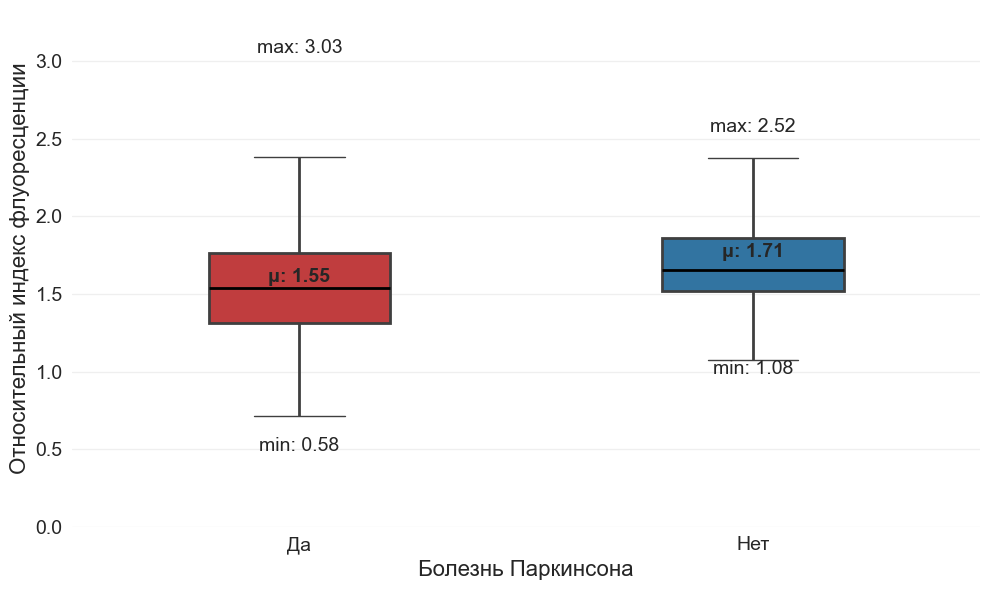

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_fluorescence_boxplot(data_with_pd, data_control, 
                             xlabel='Группы', ylabel='Относительный индекс флуоресценции',
                             title='Сравнение флуоресцентных индексов'):
    """
    Строит boxplot для сравнения флуоресцентных индексов между группами.
    
    Параметры:
    ----------
    data_with_pd : array-like
        Массив значений для группы с болезнью Паркинсона
    data_control : array-like
        Массив значений для контрольной группы
    xlabel : str, optional
        Подпись оси X (по умолчанию 'Группы')
    ylabel : str, optional
        Подпись оси Y (по умолчанию 'Относительный индекс флуоресценции')
    title : str, optional
        Заголовок графика (по умолчанию 'Сравнение флуоресцентных индексов')
    """
    
    # Создаем DataFrame для удобства построения
    df = pd.DataFrame({
        'Values': np.concatenate([data_with_pd, data_control]),
        'Group': ['Да'] * len(data_with_pd) + ['Нет'] * len(data_control)
    })
    
    # Настройка стиля
    plt.style.use('seaborn-v0_8')
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Построение boxplot
    ax = sns.boxplot(x='Group', y='Values', data=df, 
                    width=0.4, palette=['#d62728', '#1f77b4'],
                    showfliers=False,  # Не показываем выбросы
                    whiskerprops={'linewidth': 2},
                    boxprops={'linewidth': 2},
                    medianprops={'color': 'black', 'linewidth': 2})
    
    # Добавление точек для каждого наблюдения
    # sns.stripplot(x='Group', y='Values', data=df, 
    #               color='black', alpha=0.5, size=6, jitter=True)
    
    # Вычисление и отображение статистик
    stats_pd = {
        'mean': np.mean(data_with_pd),
        'min': np.min(data_with_pd),
        'max': np.max(data_with_pd)
    }
    
    stats_control = {
        'mean': np.mean(data_control),
        'min': np.min(data_control),
        'max': np.max(data_control)
    }
    
    # Добавление аннотаций со статистиками
    for i, (stats, x_pos) in enumerate(zip([stats_pd, stats_control], [0, 1])):
        ax.text(x_pos, stats['mean'], f"μ: {stats['mean']:.2f}", 
                ha='center', va='bottom', fontweight='bold', fontsize=14)
        ax.text(x_pos, stats['min'], f"min: {stats['min']:.2f}", 
                ha='center', va='top', fontsize=14)
        ax.text(x_pos, stats['max'], f"max: {stats['max']:.2f}", 
                ha='center', va='bottom', fontsize=14)
    
    # Настройка оформления
    #plt.title(title, fontsize=14, pad=20)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Добавление линии для сравнения групп
    y_max = max(np.max(data_with_pd), np.max(data_control)) * 1.1
    plt.ylim(0, y_max)
    
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_fluorescence_boxplot(data_with_pd=data.loc[data.index.get_level_values("GROUP") == "Parkinson"],
                          data_control=data.loc[data.index.get_level_values("GROUP") != "Parkinson"],
                          xlabel="Болезнь Паркинсона")

In [6]:
df_dnorm = d_norm(df_raw.copy(), "731", "772", "676")

In [ ]:
invalid_ids = df_dnorm.index.get_level_values("IDcard").unique()[-62:].tolist()
df_dnorm = df_dnorm[~df_dnorm.index.get_level_values("IDcard").isin(invalid_ids)]

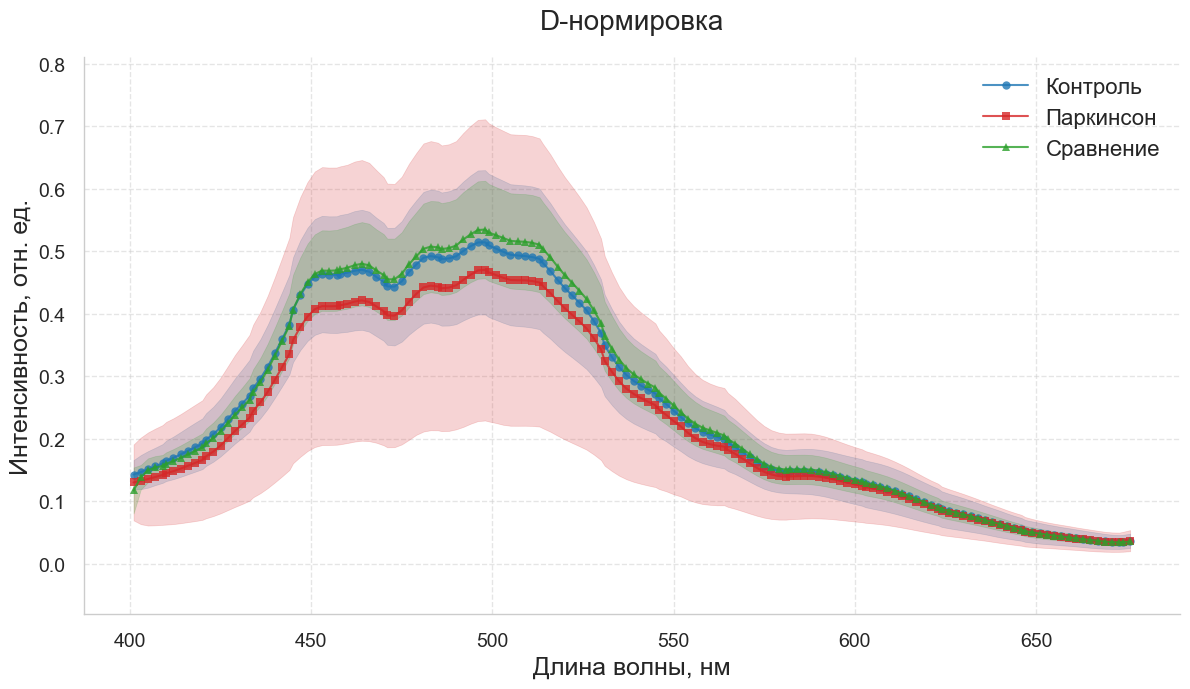

In [54]:
def sigma(x, mean):
    N = len(mean)
    return (np.sum((x - mean) ** 2, axis=0) / N) ** 0.5

start, stop = "D401", "D676"
df = df_dnorm.copy()
cont_mean = df.loc["Control", start:stop].mean(axis=0).to_numpy()
park_mean = df.loc["Parkinson", start:stop].mean(axis=0).to_numpy()
comp_mean = df.loc["Comparison", start:stop].mean(axis=0).to_numpy()

sigma_cont = sigma(df.loc["Control", start:stop].to_numpy(), cont_mean)
sigma_park = sigma(df.loc["Parkinson", start:stop].to_numpy(), park_mean)
sigma_comp = sigma(df.loc["Comparison", start:stop].to_numpy(), comp_mean)
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Предполагаем, что у вас есть временная ось (например, x = np.arange(len(cont_mean)))
x = [int(x[1:]) for x in df_dnorm.loc[:, "D401":"D676"].columns]

# Построение всех трех кривых с погрешностями
plt.errorbar(x, cont_mean, fmt='-o', 
             color='#1f77b4', ecolor='#1f77b4', alpha=0.8,
             label='Контроль', capsize=4, elinewidth=1.5)

plt.errorbar(x, park_mean, fmt='-s', 
             color='#d62728', ecolor='#d62728', alpha=0.8,
             label='Паркинсон', capsize=4, elinewidth=1.5)

plt.errorbar(x, comp_mean, fmt='-^', 
             color='#2ca02c', ecolor="#2ca12c", alpha=0.8,
             label='Сравнение', capsize=4, elinewidth=1.5)
plt.fill_between(x, cont_mean - sigma_cont, cont_mean + sigma_cont, 
                   color='#1f77b4', alpha=0.2)
plt.fill_between(x, park_mean - sigma_park, park_mean + sigma_park, 
                   color='#d62728', alpha=0.2)
plt.fill_between(x, comp_mean - sigma_comp, comp_mean + sigma_comp, 
                   color='#2ca02c', alpha=0.2)
# Дополнительное оформление

plt.xlabel('Длина волны, нм', fontsize=18)
plt.ylabel('Интенсивность, отн. ед.', fontsize=18)
plt.title("D-нормировка", fontsize=20, pad=20)
plt.legend(fontsize=16, framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Настройка сетки и осей

plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Автоматическое масштабирование осей с запасом для погрешностей
ymin = min(np.min(cont_mean - sigma_cont), 
           np.min(park_mean - sigma_park), 
           np.min(comp_mean - sigma_comp)) - 0.1
ymax = max(np.max(cont_mean + sigma_cont), 
           np.max(park_mean + sigma_park), 
           np.max(comp_mean + sigma_comp)) + 0.1
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

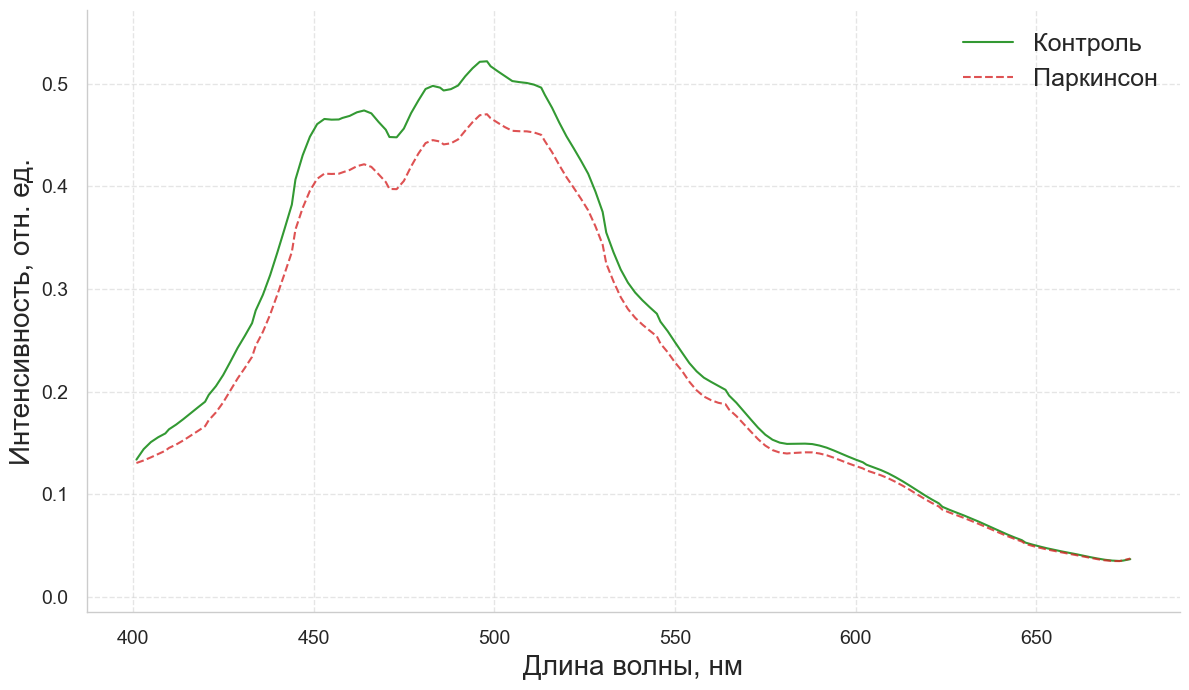

In [56]:
start, stop = "D401", "D676"
df = df_dnorm.copy()

cont_mean = df.loc[df.index.get_level_values("GROUP").isin(["Control", "Comparison"]), start:stop].mean(axis=0).to_numpy()
park_mean = df.loc["Parkinson", start:stop].mean(axis=0).to_numpy()

sigma_cont = sigma(df.loc["Control", start:stop].to_numpy(), cont_mean)
sigma_park = sigma(df.loc["Parkinson", start:stop].to_numpy(), park_mean)
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Предполагаем, что у вас есть временная ось (например, x = np.arange(len(cont_mean)))
x = [int(x[1:]) for x in df_dnorm.loc[:, "D401":"D676"].columns]

# Построение всех трех кривых с погрешностями
plt.errorbar(x, cont_mean, fmt='-', 
             color='green', ecolor='#1f77b4', alpha=0.8,
             label='Контроль', capsize=4, elinewidth=1.5)

plt.errorbar(x, park_mean, fmt='--', 
             color='#d62728', ecolor='#d62728', alpha=0.8,
             label='Паркинсон', capsize=4, elinewidth=1.5)

# plt.fill_between(x, cont_mean - sigma_cont, cont_mean + sigma_cont, 
#                    color='#1f77b4', alpha=0.2)
# plt.fill_between(x, park_mean - sigma_park, park_mean + sigma_park, 
#                    color='#d62728', alpha=0.2)
# Дополнительное оформление

plt.xlabel('Длина волны, нм', fontsize=20)
plt.ylabel('Интенсивность, отн. ед.', fontsize=20)
#plt.title("D-нормировка", fontsize=16, pad=20)
plt.legend(fontsize=18, framealpha=1)

# Настройка сетки и осей
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Автоматическое масштабирование осей с запасом для погрешностей
ymin = min(np.min(cont_mean), 
           np.min(park_mean)) - 0.05
ymax = max(np.max(cont_mean), 
           np.max(park_mean)) + 0.05
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## I-нормировка

In [3]:
from sklearn.linear_model import LinearRegression
def i_norm(data_dnorm: pd.DataFrame) -> pd.DataFrame:
    data_Inorm_arr = []
    reg = LinearRegression()
    for group in data_dnorm.index.get_level_values("GROUP").unique():
        data_buf = data_dnorm[
            data_dnorm.index.get_level_values("GROUP").isin([group])
            ]
        mean_values = data_buf.mean().to_numpy().reshape(-1, 1)
        for i in range(len(data_buf)):
            x = np.array(
                list(data_buf.iloc[i])
                ).reshape(-1, 1)
            reg.fit(mean_values, x)
            A, B = reg.coef_[0][0], reg.intercept_[0]
            x = (x - B) / A
            data_Inorm_arr.append(x.reshape(-1,))

    data_Inorm = np.asarray(data_Inorm_arr)
    data_Inorm = pd.DataFrame(data_Inorm,
                              columns=data_dnorm.keys(),
                              index=data_dnorm.index
                            )

    data_Inorm.columns = [f"I{i[1:]}" if i[0] == "D" 
                          else f"I{i}" 
                          for i in data_Inorm.keys()]
    return data_Inorm

In [ ]:
from sklearn.linear_model import LinearRegression
def i_norm(data_dnorm: pd.DataFrame) -> pd.DataFrame:
    data_Inorm_arr = []
    reg = LinearRegression()
    data_buf = data_dnorm
    mean_values = data_buf.mean().to_numpy().reshape(-1, 1)
    for i in range(len(data_buf)):
        x = np.array(
            list(data_buf.iloc[i])
            ).reshape(-1, 1)
        reg.fit(mean_values, x)
        A, B = reg.coef_[0][0], reg.intercept_[0]
        x = (x - B) / A
        data_Inorm_arr.append(x.reshape(-1,))

    data_Inorm = np.asarray(data_Inorm_arr)
    data_Inorm = pd.DataFrame(data_Inorm,
                              columns=data_dnorm.keys(),
                              index=data_dnorm.index
                            )

    data_Inorm.columns = [f"I{i[1:]}" if i[0] == "D" 
                          else f"I{i}" 
                          for i in data_Inorm.keys()]
    return data_Inorm

In [22]:
df_inorm = i_norm(df_dnorm)

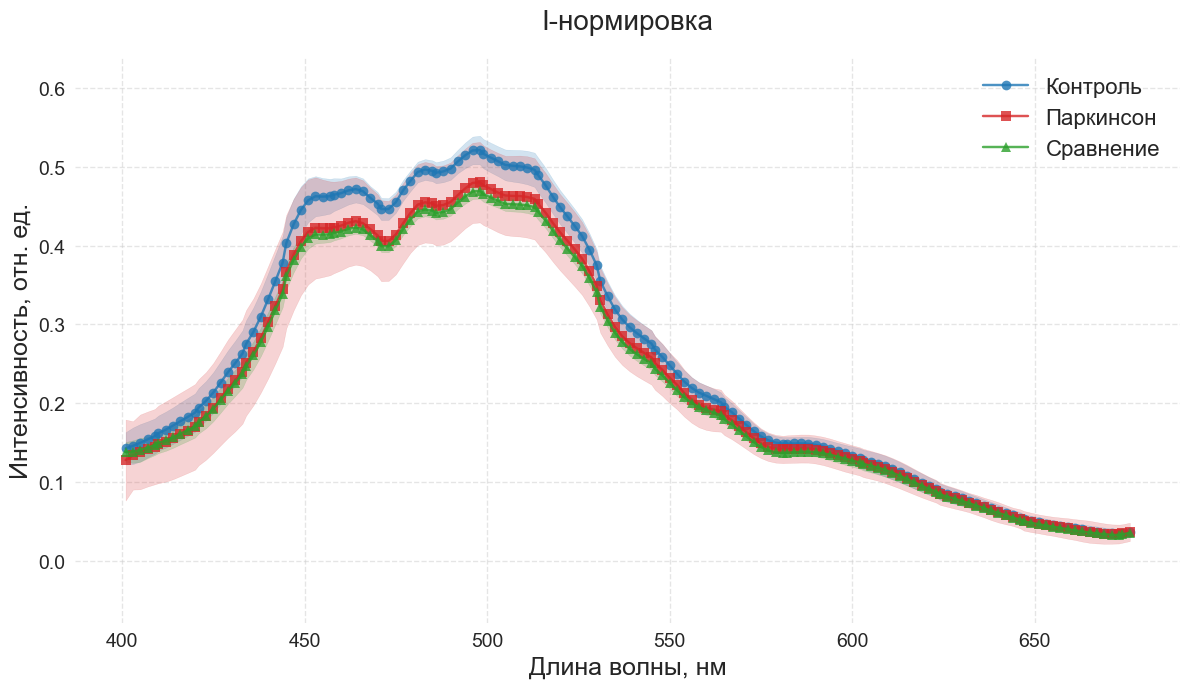

In [27]:
def sigma(x, mean):
    N = len(mean)
    return (np.sum((x - mean) ** 2, axis=0) / N) ** 0.5

start, stop = "I401", "I676"
df = df_inorm.copy()
cont_mean = df.loc["Control", start:stop].mean(axis=0).to_numpy()
park_mean = df.loc["Parkinson", start:stop].mean(axis=0).to_numpy()
comp_mean = df.loc["Comparison", start:stop].mean(axis=0).to_numpy()

sigma_cont = sigma(df.loc["Control", start:stop].to_numpy(), cont_mean)
sigma_park = sigma(df.loc["Parkinson", start:stop].to_numpy(), park_mean)
sigma_comp = sigma(df.loc["Comparison", start:stop].to_numpy(), comp_mean)
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Предполагаем, что у вас есть временная ось (например, x = np.arange(len(cont_mean)))
x = [int(x[1:]) for x in df_inorm.loc[:, "I401":"I676"].columns]

# Построение всех трех кривых с погрешностями
plt.errorbar(x, cont_mean, fmt='-o', 
             color='#1f77b4', ecolor='#1f77b4', alpha=0.8,
             label='Контроль', capsize=4, elinewidth=1.5)

plt.errorbar(x, park_mean, fmt='-s', 
             color='#d62728', ecolor='#d62728', alpha=0.8,
             label='Паркинсон', capsize=4, elinewidth=1.5)

plt.errorbar(x, comp_mean, fmt='-^', 
             color='#2ca02c', ecolor='#2ca02c', alpha=0.8,
             label='Сравнение', capsize=4, elinewidth=1.5)
plt.fill_between(x, cont_mean - sigma_cont, cont_mean + sigma_cont, 
                   color='#1f77b4', alpha=0.2)
plt.fill_between(x, park_mean - sigma_park, park_mean + sigma_park, 
                   color='#d62728', alpha=0.2)
plt.fill_between(x, comp_mean - sigma_comp, comp_mean + sigma_comp, 
                   color='#2ca02c', alpha=0.2)
# Дополнительное оформление

plt.xlabel('Длина волны, нм', fontsize=18)
plt.ylabel('Интенсивность, отн. ед.', fontsize=18)
plt.title("I-нормировка", fontsize=20, pad=20)
plt.legend(fontsize=16, framealpha=1)
# Настройка сетки и осей
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Автоматическое масштабирование осей с запасом для погрешностей
ymin = min(np.min(cont_mean - sigma_cont), 
           np.min(park_mean - sigma_park), 
           np.min(comp_mean - sigma_comp)) - 0.1
ymax = max(np.max(cont_mean + sigma_cont), 
           np.max(park_mean + sigma_park), 
           np.max(comp_mean + sigma_comp)) + 0.1
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Optional, Union, List

def plot_fluorescence_spectra(
    data: pd.DataFrame,
    x_col: str = 'wavelength',
    y_col: str = 'intensity',
    group_col: str = 'GROUP',
    groups: Optional[Dict[str, str]] = None,
    style: str = 'whitegrid',
    palette: Union[str, List[str], Dict[str, str]] = 'coolwarm',
    figsize: tuple = (12, 6),
    title: str = 'Средние спектры аутофлуоресценции кожи',
    xlabel: str = 'Длина волны (нм)',
    ylabel: str = 'Интенсивность (отн. ед.)',
    ci: int = 95,
    estimator: str = 'mean',
    rotation: int = 45,
    grid_alpha: float = 0.3,
    legend_title: str = 'Группы',
    line_styles: Optional[Dict[str, tuple]] = None,  # Изменено на tuple
    line_width: int = 2,
    font_scale: float = 1.2,
    context: str = 'notebook',
    save_path: Optional[str] = None,
    **kwargs
):
    """
    Построение спектров аутофлуоресценции с настройкой стилей.
    
    Параметры:
    ----------
    line_styles : dict, optional
        Стили линий для групп в формате {'group_name': (on, off)}
        Например: {'Control': (2, 1), 'Diabetes': (4, 1)}
    """
    # Настройка стилей
    plt.style.use("seaborn-v0_8")
    sns.set_style(style)
    sns.set_context(context, font_scale=font_scale)
    
    if isinstance(palette, str) and groups:
        palette = list(groups.values())
    
    # Создание фигуры
    plt.figure(figsize=figsize)
    
    # Подготовка параметров стиля линий
    style_params = {}
    if line_styles:
        style_params['style'] = group_col
        style_params['dashes'] = line_styles
    
    # Построение графиков
    lineplot = sns.lineplot(
        data=data,
        x=x_col,
        y=y_col,
        hue=group_col,
        errorbar=('ci', ci),
        estimator=estimator,
        palette=palette,
        linewidth=line_width,
        **style_params,
        **kwargs
    )
    
    # Настройка оформления
    plt.title(title, pad=20, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xticks(rotation=rotation, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(alpha=grid_alpha)
    
    # Настройка легенды
    handles, labels = lineplot.get_legend_handles_labels()
    translate = {"Control": "Контроль", "Parkinson": "Паркинсон", "Comparison": "Сравнение"}
    labels = [translate[val] for val in labels]
    plt.legend(
        title=legend_title,
        handles=handles,
        labels=labels,
        frameon=True,
        fontsize=14,
        framealpha=0.8
    )
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()




In [4]:
df_raw.set_index("level_3", append=True, inplace=True)

In [3]:
colors = sns.color_palette("husl", 3)
colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744)]

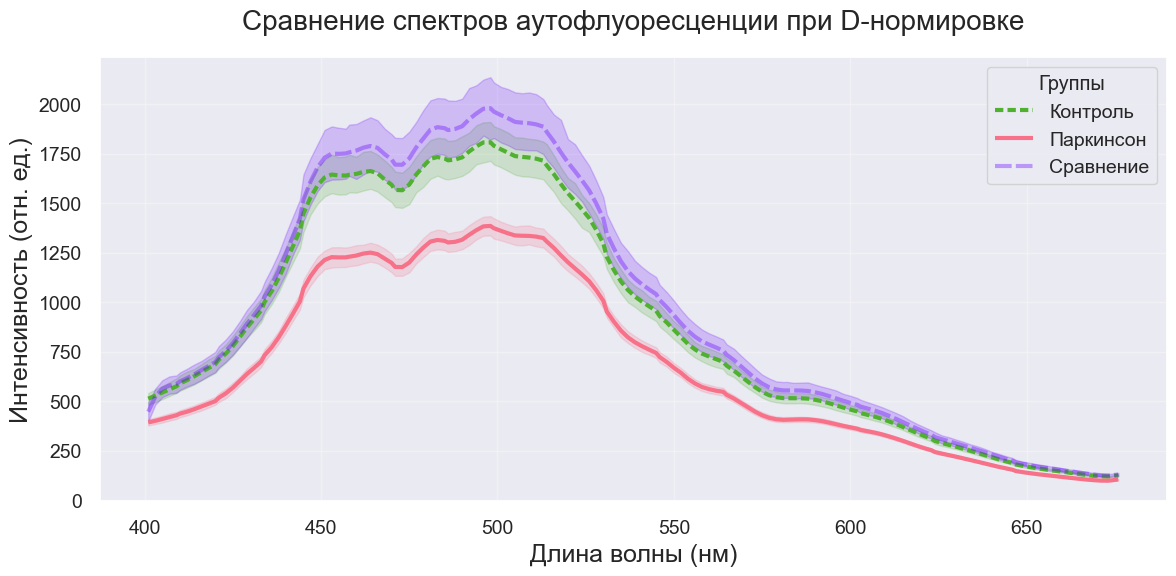

In [7]:
func = lambda x: int(x[1:]) if x[0] in ["D", "I"] else int(x)
df_err = df_raw[df_raw.columns[:147]].reset_index(level="GROUP").melt(id_vars='GROUP', var_name='wavelength', value_name='intensity')
df_err['wavelength'] = df_err['wavelength'].apply(func)
plot_fluorescence_spectra(
    data=df_err,
    groups={'Control': colors[1], 'Comparison': colors[0], 'Parkinson': "#6200ff5a"},
    line_styles={'Control': (2, 1), 'Comparison': (4, 1), 'Parkinson': (1, 0)},
    line_width=3,
    title='Сравнение спектров аутофлуоресценции при D-нормировке',
    ci=98,
    style ='darkgrid',
    palette = 'coolwarm',
    rotation=0
)

# Статистическая обработка

## Проверка на нормальность

In [ ]:

def plot_intensity_histograms(data: pd.DataFrame, 
                             wave_list: list,
                             bins: int = 30,
                             figsize: tuple = (14, 8),
                             palette: str = "viridis",
                             kde: bool = True,
                             stat: str = "density",
                             common_norm: bool = False) -> None:
    """
    Строит гистограммы распределения интенсивностей для заданных длин волн.
    
    Параметры:
    ----------
    data : pd.DataFrame
        DataFrame с спектральными данными (столбцы - длины волн, строки - измерения)
    wave_list : List[float]
        Список длин волн для анализа
    bins : int, optional
        Количество бинов в гистограмме (по умолчанию 30)
    figsize : tuple, optional
        Размер фигуры (по умолчанию (14, 8))
    palette : str, optional
        Цветовая палитра (по умолчанию "viridis")
    kde : bool, optional
        Если True, добавляет KDE оценку (по умолчанию True)
    stat : str, optional
        Тип статистики ("count", "frequency", "density", "probability")
    common_norm : bool, optional
        Нормализовать ли все гистограммы одинаково (по умолчанию False)
    """
    
    # Проверка наличия длин волн в данных
    missing_waves = [w for w in wave_list if w not in data.columns]
    if missing_waves:
        raise ValueError(f"Длины волн {missing_waves} не найдены в данных")
    
    # Настройка стиля
    sns.set_style("whitegrid")
    
    # Создаем сетку подграфиков
    n_waves = len(wave_list)
    n_cols = min(2, n_waves)
    n_rows = (n_waves + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_waves > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Цветовая палитра
    colors = sns.color_palette(palette, n_waves)
    
    # Находим общие пределы для одинакового масштабирования
    if common_norm:
        all_data = data[wave_list].values.flatten()
        x_min, x_max = np.nanmin(all_data), np.nanmax(all_data)
    
    for i, (wave, ax) in enumerate(zip(wave_list, axes)):
        wave_data = data[wave].dropna()
        
        # Построение гистограммы
        sns.histplot(data=wave_data, 
                     bins=bins,
                     kde=kde,
                     color=colors[i],
                     stat=stat,
                     alpha=0.7,
                     edgecolor='white',
                     linewidth=0.5,
                     ax=ax)
        
        # Установка одинаковых пределов если нужно
        if common_norm:
            ax.set_xlim(x_min, x_max)
        
        # Настройка оформления
        ax.set_title(f'Длина волны: {wave[1:]} нм', fontsize=12, pad=10)
        ax.set_xlabel('Интенсивность, отн. ед.', fontsize=12)
        ax.set_ylabel("Плотность, усл. ед.", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # Добавляем аннотацию с базовой статистикой
        stats_text = (f"μ = {wave_data.mean():.2f}\n"
                     f"σ = {wave_data.std():.2f}\n"
                     f"N = {len(wave_data)}")
        ax.annotate(stats_text, xy=(0.95, 0.95), 
                    xycoords='axes fraction',
                    ha='right', va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Скрываем пустые subplots
    for j in range(n_waves, len(axes)):
        axes[j].axis('off')
    
    # Общий заголовок
    # fig.suptitle('Распределение интенсивностей по длинам волн', 
    #              fontsize=16, y=1.02)
    
    plt.tight_layout()
    plt.show()

In [42]:
df_dnorm = d_norm(df_raw, "731", "772", "676")

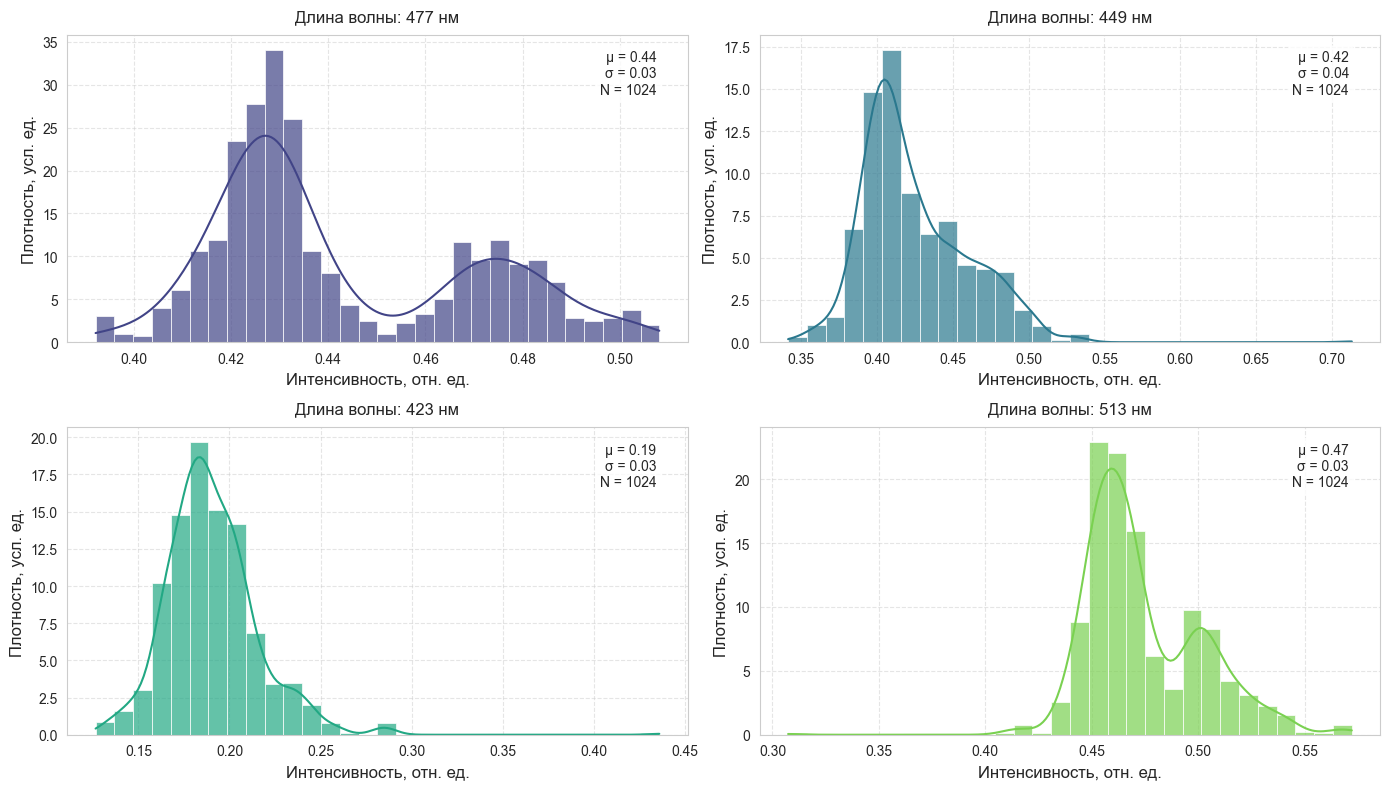

In [ ]:
from random import choices
waves = choices(df_inorm.columns.tolist(), k=4)
plot_intensity_histograms(df_inorm, waves)

In [ ]:
from scipy.stats import shapiro

max = 0
for wave in df_inorm.columns:
    s, p = shapiro(df_inorm[wave])
    if p > max:
        max = p
        max_s = s
        wave_max = wave
print(max, max_s, wave)

1.22633879708116e-05 0.9914885853335447 I676


## Z-оценки

Text(0.5, 0, 'Длина волны, нм')

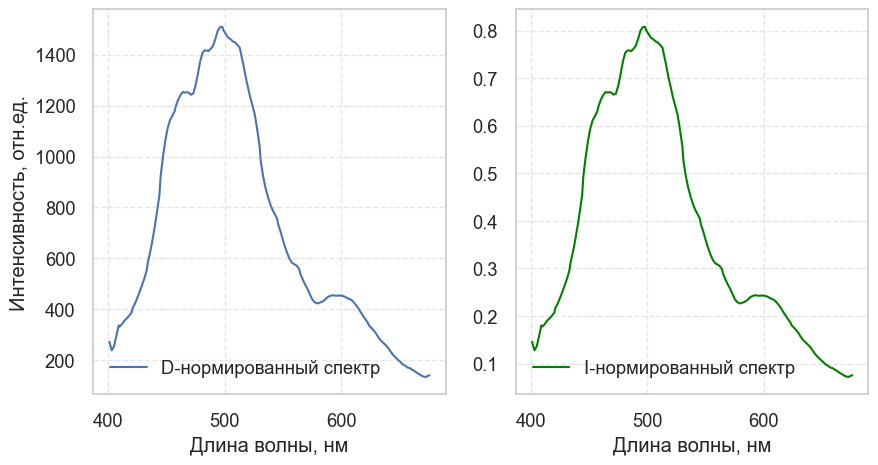

In [43]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
x = [int(val) for val in df_raw]
ax[0].plot(x[:147], df_raw.loc[df_raw.index[0]].tolist()[:147])
ax[0].grid(True, linestyle='--', alpha=0.5)
ax[0].legend(["D-нормированный спектр"])
ax[0].set_xlabel("Длина волны, нм")
ax[0].set_ylabel("Интенсивность, отн.ед.")
ax[1].plot(x[:147], df_dnorm.loc[df_dnorm.index[0]].tolist(), color="green")
ax[1].grid(True, linestyle='--', alpha=0.5)
ax[1].legend(["I-нормированный спектр"])
ax[1].set_xlabel("Длина волны, нм")

In [59]:
from scipy import stats
def compute_Z(data, start, stop):
    """
        Функция для рассчета Z-оценок по подгруппам Паркинсон, Контроль, Сравнение
        
        data: pd.DataFrame - данные
        start: pd.Index - начало исследуемого участка спектра
        stop: pd.Index - конец исследуемого участка
    """
    Z_cont_park = []
    Z_comp_park = []
    Z_comp_cont = []
    df_cont = data.loc[data.index.get_level_values(level=0) == "Control", start:stop].copy()
    df_park = data.loc[data.index.get_level_values(level=0) == "Parkinson", start:stop].copy()
    df_comp = data.loc[data.index.get_level_values(level=0) == "Comparison", start:stop].copy()
    try:
        preds = [int(val)for val in df_cont.keys()]
    except:
        preds = [int(val[1:])for val in df_cont.keys()]
    
    n1 = len(df_cont)
    n2 = len(df_park)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_cont[predictor], df_park[predictor])
        Z_cont_park.append((float(U) - mU) / sigma_U)
    n1 = len(df_comp)
    n2 = len(df_park)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_comp[predictor], df_park[predictor])
        Z_comp_park.append((float(U) - mU) / sigma_U)
    n1 = len(df_comp)
    n2 = len(df_cont)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_comp[predictor], df_cont[predictor])
        Z_comp_cont.append((float(U) - mU) / sigma_U)
    
    return Z_cont_park, Z_comp_park, Z_comp_cont, preds

In [60]:
from scipy import stats
def compute_z_score(data1: pd.DataFrame, data2: pd.DataFrame):
    Z = []
    n1 = len(data1)
    n2 = len(data2)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in data1.keys():
        U, _ = stats.mannwhitneyu(data1[predictor],
                                  data2[predictor])
        Z.append((float(U) - mU) / sigma_U)
    return Z

In [61]:
def print_z_info(z, Z_name):
    z = np.array(z)
    Z_min = np.min(z, axis=1)
    Z_max = np.max(z, axis=1)
    Z_mean = np.mean(z, axis=1)
    Z_std = np.std(z, axis=1)
    for z_min, z_max, z_mean, z_std, z_name in zip(Z_min, Z_max, Z_mean, Z_std, Z_name):
        print(f"{z_name}")
        print(f"min: {z_min}")
        print(f"max: {z_max}")
        print(f"mean: {z_mean}")
        print(f"std: {z_std}")
        print()

In [62]:
Z_cont_park, Z_comp_park, Z_comp_cont, preds = compute_Z(df_dnorm, start="D403", stop="D676")
z = np.array([Z_cont_park, Z_comp_park, Z_comp_cont])
Z_name = ["Control-Parkinson", "Comparison-Parkinson", "Control-Comparison"]

In [49]:
print_z_info(z, Z_name)

Control-Parkinson
min: -1.8288691762705556
max: 9.77142132951306
mean: 4.279183819354528
std: 3.3361352455826703

Comparison-Parkinson
min: -1.026587011943355
max: 7.448207483303076
mean: 4.928590221910442
std: 2.2421149943908634

Control-Comparison
min: -3.086179615272368
max: 2.3088927008108984
mean: 1.066805135322313
std: 1.204515940784576



In [68]:
df_raw.loc[df_raw.index.get_level_values(level="IDcard").isin(df_raw.index.get_level_values(level="IDcard")[:528])]

401         403         405  \
GROUP     IDcard hand  level_3                                          
Control   CG1    right CG1_1       272.182526  238.924606  254.722214   
                       CG1_2       250.095245  258.071442  264.214294   
                       CG1_3       226.452377  225.785721  228.857147   
                       CG1_4       214.261902  215.357147  216.714279   
                       CG1_5       200.880951  212.476196  216.047623   
...                                       ...         ...         ...   
Parkinson БП008  right БП008(П)_4  122.690475  127.761902  130.476196   
                       БП008(П)_5  122.190475  126.404762  130.047623   
                       БП008(П)_6  118.119049  128.142853  131.857147   
                       БП008(П)_7  124.833336  125.047623  126.547623   
                       БП008(П)_8  130.666672  125.309525  124.666664   

                                          407         409         410  \
GROUP     IDcard hand  level_3                                          
Control   CG1    right CG1_1       295.547607  336.968262  332.523804   
                       CG1_2       269.523804  274.571442  282.190491   
                       CG1_3       234.666672  242.047623  249.761902   
                       CG1_4       219.333328  225.523804  232.285721   
                       CG1_5       216.428574  221.714279  230.619049   
...                                       ...         ...         ...   
Parkinson БП008  right БП008(П)_4  131.666672  131.761902  133.523804   
                       БП008(П)_5  132.952377  134.333328  135.714279   
                       БП008(П)_6  131.761902  131.809525  130.380951   
                       БП008(П)_7  128.666672  129.857147  131.857147   
                       БП008(П)_8  126.904762  129.095245  132.047623   

                                          412         414         416  \
GROUP     IDcard hand  level_3                                          
Control   CG1    right CG1_1       342.809509  355.809509  364.428558   
                       CG1_2       292.142853  300.285706  310.428558   
                       CG1_3       261.095245  272.095245  280.857147   
                       CG1_4       244.666672  251.047623  258.857147   
                       CG1_5       239.523804  249.523804  257.761902   
...                                       ...         ...         ...   
Parkinson БП008  right БП008(П)_4  137.238098  144.285721  151.476196   
                       БП008(П)_5  137.571426  141.380951  146.761902   
                       БП008(П)_6  133.333328  139.841263  146.785721   
                       БП008(П)_7  137.190475  143.952377  150.142853   
                       БП008(П)_8  134.380951  140.015869  144.952377   

                                          418  ...  803  805  807  809  811  \
GROUP     IDcard hand  level_3                 ...                            
Control   CG1    right CG1_1       374.904755  ...   41   34   28   38   29   
                       CG1_2       322.000000  ...   32   33   31   39   25   
                       CG1_3       288.523804  ...   21   24   25   28   32   
                       CG1_4       267.761902  ...   33   18   22   25   18   
                       CG1_5       262.333344  ...   27   22   16   19   15   
...                                       ...  ...  ...  ...  ...  ...  ...   
Parkinson БП008  right БП008(П)_4  156.714279  ...   17    7   -2    6    6   
                       БП008(П)_5  152.428574  ...   15   12   16   10    9   
                       БП008(П)_6  153.333328  ...   11    9    7    3    1   
                       БП008(П)_7  154.714279  ...   16    8   11   15    2   
                       БП008(П)_8  150.952377  ...   11    8   13    8    7   

                                   813  815  817  819  821  
GROUP     IDcard hand  level_3                              
Control   CG1    right CG1_1        35   3

In [70]:
df_raw_1  = df_raw.loc[df_raw.index.get_level_values(level="IDcard").isin(df_raw.index.get_level_values(level="IDcard")[:528])].copy()

In [71]:
df_raw_1 = df_raw.loc[df_raw.index.get_level_values(level="IDcard").isin(df_raw.index.get_level_values(level="IDcard")[:528])].copy()
df_dnorm = d_norm(df_raw_1, "731", "772", "676")
df_inorm = i_norm(df_dnorm)

In [69]:
inds = ['БП009', 'БП010',
       'БП011', 'БП012', 'БП013', 'БП014', 'БП015', 'БП016', 'БП017', 'БП018',
       'БП019', 'БП020', 'БП021', 'БП022', 'БП023', 'БП024', 'БП025', 'БП026',
       'БП027', 'БП028', 'БП029', 'БП030', 'БП031', 'БП032', 'БП033', 'БП034',
       'БП035', 'БП036', 'БП037', 'КОНТРОЛЬ-1', 'КОНТРОЛЬ-2', 'КОНТРОЛЬ-4']

In [73]:
df_dnorm = df_dnorm.loc[~df_dnorm.index.isin(inds, level=1)]
df_inorm = df_inorm.loc[~df_inorm.index.isin(inds, level=1)]


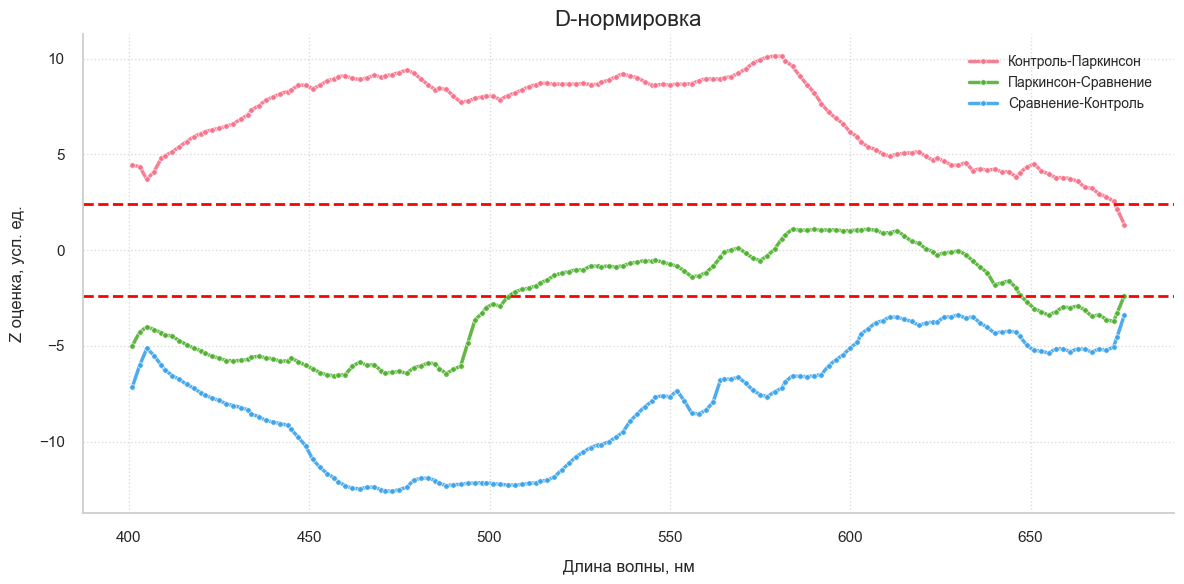

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_z(Z, Z_name, preds):
    # Настройка стиля
    plt.style.use('seaborn-v0_8')  # Используем актуальный стиль seaborn
    sns.set_theme(style="whitegrid")  # Альтернативный способ установки стиля
    
    # Создание фигуры с настроенным размером
    plt.figure(figsize=(12, 6), dpi=100)
    
    # Цветовая палитра (используем seaborn)
    colors = sns.color_palette("husl", len(Z))
    
    # Рисуем основные кривые
    for z, name, color in zip(Z, Z_name, colors):
        plt.plot(preds, z, 
                 linewidth=2.5,
                 alpha=0.9,
                 color=color,
                 label=name,
                 marker='o',
                 markersize=4,
                 markeredgecolor='white',
                 markeredgewidth=0.5)
    
    # Критическое значение Z
    plt.axhline(y=2.39, color="red", linestyle="--", linewidth=2)
    plt.axhline(y=-2.39, color="red", linestyle="--", linewidth=2)
    # Настройка осей и заголовков
    plt.title("D-нормировка", fontsize=16)
    plt.xlabel("Длина волны, нм", fontsize=12, labelpad=10) 
    plt.ylabel("Z оценка, усл. ед.", fontsize=12, labelpad=10)

    
    # Настройка сетки
    plt.grid(True, linestyle=':', alpha=0.7)
    
    # Легенда
    legend = plt.legend(fontsize=10, framealpha=1, 
                       shadow=True, borderpad=1,
                       loc='upper right')
    legend.get_frame().set_facecolor('white')
    
    # Улучшенные пределы осей
    # plt.xlim(min(preds), max(preds))
    # y_max = max(np.max(Z), 2.39) * 1.1  # 10% запас сверху
    # plt.ylim(0, y_max)
    
    # Убираем верхнюю и правую рамку
    sns.despine()
    
    plt.tight_layout()
    plt.show()

# Пример вызова
Z_cont_park, Z_comp_park, Z_comp_cont, preds = compute_Z(df_inorm, start="I401", stop="I676")
# z = np.array([Z_cont_park, [-z for z in Z_comp_park], [-z for z in Z_comp_cont]])
z = np.array([Z_cont_park, Z_comp_park, Z_comp_cont])
Z_name = ["Контроль-Паркинсон", "Паркинсон-Сравнение", "Сравнение-Контроль"]
draw_z(z, Z_name, preds)

# Машинное обучение

## Разделение на выборки

In [4]:
df_raw = pd.read_excel("./data/df_raw.xlsx", index_col=[0, 1, 2, 3])

Вывод гистограммы распределения

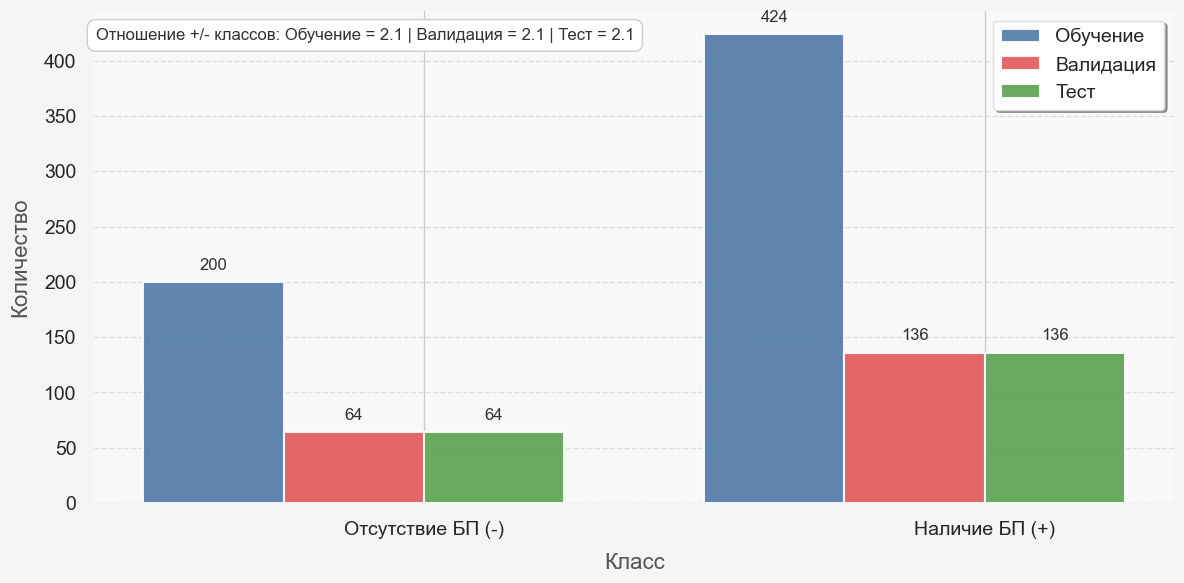

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Предполагаем, что df_dnorm уже определен


# Подсчёт количества элементов каждого класса
train_counts = np.bincount(y_train_noaug)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Стиль графика
plt.style.use('seaborn-v0_8-pastel')
sns.set_palette("husl")
plt.figure(figsize=(12, 6), facecolor='#f5f5f5')
plt.gca().set_facecolor('#f9f9f9')

# Настройки визуализации
width = 0.25
colors = ['#4e79a7', '#e15759', '#59a14f']  # Синий, красный, зелёный
group_labels = ['Обучение', 'Валидация', 'Тест']
class_labels = ['Отсутствие БП (-)', 'Наличие БП (+)']

# Построение столбцов
for i, (counts, color) in enumerate(zip([train_counts, val_counts, test_counts], colors)):
    positions = np.arange(2) + i*width - width
    bars = plt.bar(positions, counts, width, 
                  label=group_labels[i], color=color,
                  edgecolor='white', linewidth=1.5, alpha=0.9, zorder=3)
    
    # Добавление аннотаций
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + max(*train_counts, *val_counts, *test_counts)*0.02,
                f'{int(height)}', ha='center', va='bottom', fontsize=12, color='#333333')

# Настройка осей
plt.xlabel('Класс', fontsize=16, labelpad=10, color='#555555')
plt.ylabel('Количество', fontsize=16, labelpad=10, color='#555555')
plt.xticks(np.arange(2) + width/2, class_labels, fontsize=14)
plt.yticks(fontsize=14)

# Легенда
plt.legend(frameon=True, shadow=True, facecolor='white', 
           edgecolor='#dddddd', fontsize=14, loc='upper right')

# Расчёт и отображение соотношений
train_ratio = train_counts[1]/train_counts[0]
val_ratio = val_counts[1]/val_counts[0]
test_ratio = test_counts[1]/test_counts[0]

plt.text(0.5, 0.95, 
        f'Отношение +/- классов: Обучение = {train_ratio:.1f} | Валидация = {val_ratio:.1f} | Тест = {test_ratio:.1f}',
        ha='right', va='center', transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', edgecolor='#cccccc', boxstyle='round,pad=0.5'),
        fontsize=12, color='#333333')

# Сетка и оформление
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

Функция для аугментации

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm


def augment_spectrum(spectrum, n_augment=5, noise_scale=0.01, stretch_range=0.02):
    """
    Генерация аугментированных спектров с сохранением физических характеристик
    
    Параметры:
    ----------
    spectrum : np.array
        Исходный спектр
    n_augment : int
        Количество аугментированных вариантов
    noise_scale : float
        Уровень шума (доля от среднего значения спектра)
    shift_range : int
        Максимальный сдвиг по оси X (в точках)
    stretch_range : float
        Относительное растяжение/сжатие по оси X
    
    Возвращает:
    -----------
    augmented : list of np.array
        Список аугментированных спектров
    """
    augmented = [spectrum]
    base_noise = noise_scale * np.mean(spectrum)
    
    for _ in range(n_augment):
        # 1. Добавление гауссова шума
        noise = np.random.normal(0, base_noise, len(spectrum))
        aug = spectrum + noise
        
        
        # 3. Нелинейное растяжение по оси X (имитация калибровки)
        if stretch_range > 0:
            x_orig = np.linspace(0, 1, len(spectrum))
            x_new = x_orig * (1 + np.random.uniform(-stretch_range, stretch_range))
            aug = np.interp(x_orig, x_new, aug)
        
        # 4. Коррекция базовой линии
        baseline = np.random.uniform(-base_noise, base_noise)
        aug += baseline
        
        augmented.append(aug)
    
    return augmented

def create_augmented_dataset(df, target_column='GROUP', log=False, n_augment_per_class=5, noise_scale=0.01, stretch_range=0.02, random_state=42):
    """
    Создание аугментированного датасета
    
    Параметры:
    ----------
    df : pd.DataFrame
        Исходный датасет (спектры в столбцах, метки в target_column)
    target_column : str
        Название столбца с метками классов
    n_augment_per_class : int or dict
        Количество аугментаций на образец (может быть словарем для разных классов)
    random_state : int
        Seed для воспроизводимости
    
    Возвращает:
    -----------
    augmented_df : pd.DataFrame
        Новый датасет с аугментированными данными
    """
    np.random.seed(random_state)
    augmented_data = []
    spectra_columns = [col for col in df.columns if col != target_column]
    
    if isinstance(n_augment_per_class, int):
        n_augment_per_class = {cls: n_augment_per_class for cls in df[target_column].unique()}
    
    if log == True:
        origin = tqdm(df.groupby(target_column), desc="Аугментация классов")
    else:
        origin = df.groupby(target_column)
    for label, group in origin:
        n_augment = n_augment_per_class.get(label, 0)
        
        for _, row in group.iterrows():
            spectrum = row[spectra_columns].values.astype('float32')
            augmented_data.append(row.to_dict())  # Оригинальный образец
            
            if n_augment > 0:
                augmented_spectra = augment_spectrum(spectrum, n_augment=n_augment, noise_scale=noise_scale, stretch_range=stretch_range)
                
                for aug_spectrum in augmented_spectra:
                    new_row = row.copy()
                    new_row[spectra_columns] = aug_spectrum.astype('float32')
                    augmented_data.append(new_row.to_dict())
    
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df



In [7]:
from sklearn.model_selection import train_test_split

idx = pd.IndexSlice
X = df_raw.copy()
y = pd.Series([1 if x == "Parkinson" else 0 for x in df_raw.index.get_level_values("GROUP").to_list()], index = df_raw.index)
y_buf = y.groupby(level=1).max()
y_train, y_temp = train_test_split(y_buf, stratify=y_buf, test_size=0.4, random_state=33)
y_val, y_test = train_test_split(y_temp, stratify=y_temp, test_size=0.5, random_state=33)
X_train = X.loc[idx[:, y_train.index, :]]
X_val = X.loc[idx[:, y_val.index, :]]
X_test = X.loc[idx[:, y_test.index, :]]
y_train = y.loc[idx[:, y_train.index, :]]
y_val = y.loc[idx[:, y_val.index, :]]
y_test = y.loc[idx[:, y_test.index, :]]

X_train_noaug = X_train.copy()
y_train_noaug = y_train.copy()

In [8]:
#X_train = d_norm(X_train, "731", "772", "676")
X_val = d_norm(X_val, "731", "772", "676")
X_test = d_norm(X_test, "731", "772", "676")
X_train_noaug = d_norm(X_train_noaug, "731", "772", "676")

In [13]:
df_train = X_train.copy()
df_train["target"] = y_train

In [14]:
augmented_df = create_augmented_dataset(
    df_train,
    target_column='target',
    n_augment_per_class={1: 2, 0: 2},
    random_state=42,
    noise_scale=0.015,
    stretch_range=0.02,
) 
augmented_df["index"] = [i for i in range(augmented_df.shape[0])]
augmented_df.set_index(['target', 'index'], inplace=True)
augmented_df = d_norm(augmented_df, "731", "772", "676")

In [15]:
X_train = augmented_df
y_train = augmented_df.index.get_level_values('target').to_list()
y_train = pd.Series(y_train)

In [16]:
X_val = d_norm(X_val, "731", "772", "676")
X_test = d_norm(X_test, "731", "772", "676")
X_train_noaug = d_norm(X_train_noaug, "731", "772", "676")

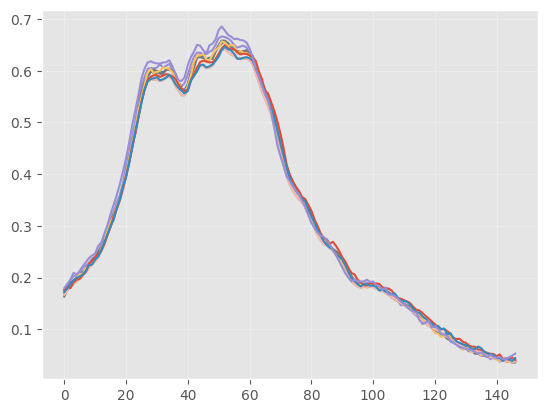

In [ ]:
index = X_train.index[0:10]
for ind in index:
    plt.plot(range(X_train.columns.__len__()), X_train.loc[ind])

In [ ]:
from sklearn.decomposition import PCA
pca_aug = PCA()
X_train_noaug = pd.DataFrame(pca_aug.fit_transform(X_train_noaug), index=X_train_noaug.index)
X_train = pd.DataFrame(pca_aug.transform(X_train), index=X_train.index)
X_val = pd.DataFrame(pca_aug.transform(X_val), index=X_val.index)
X_test = pd.DataFrame(pca_aug.transform(X_test), index=X_test.index)


In [ ]:
pca = PCA(n_components=2)
X_train_noaug_1 = pd.DataFrame(pca.fit_transform(X_train_noaug), index=X_train_noaug.index)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
X_train_noaug_1 = pd.DataFrame(tsne.fit_transform(X_train_noaug), index=X_train_noaug.index)

c:\Users\nikba\.vscode\Projects\Scientific_work\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nikba\.vscode\Projects\Scientific_work\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareF

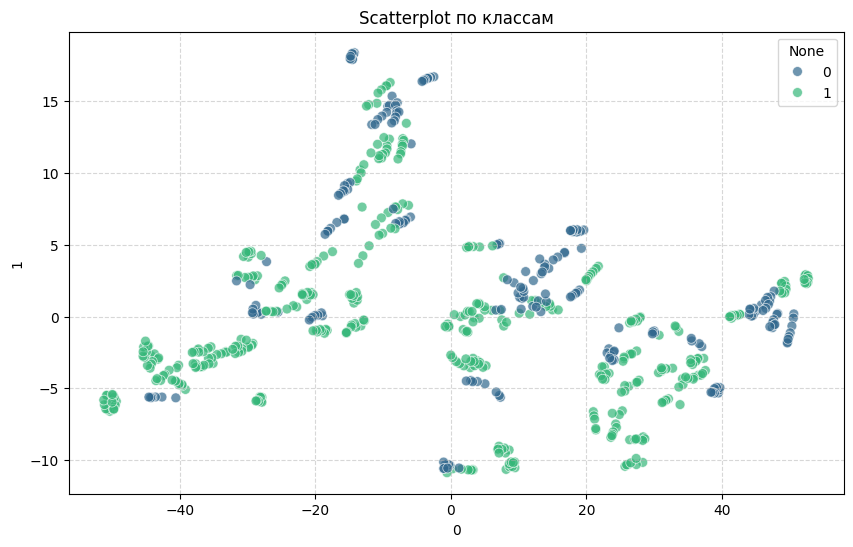

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что:
# - X_train_noaug — pd.DataFrame с признаками (минимум 2 столбца для осей X и Y)
# - y_train_noaug — массив меток классов (например, [0, 1, 0, 2, ...])

# Проверка данных

# Выбираем первые 2 признака для осей (или любые другие)
feature1 = X_train_noaug_1.columns[0]  # Первый признак
feature2 = X_train_noaug_1.columns[1]  # Второй признак

# Создаем scatterplot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x=X_train_noaug_1[feature1],
    y=X_train_noaug_1[feature2],
    hue=y_train_noaug,          # Цвета по меткам классов
    palette='viridis',           # Палитра (можно выбрать 'rainbow', 'plasma', и т.д.)
    alpha=0.7,                # Прозрачность точек
    edgecolors='w',           # Границы точек — белые
    s=50                      # Размер точек
)

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Scatterplot по классам")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

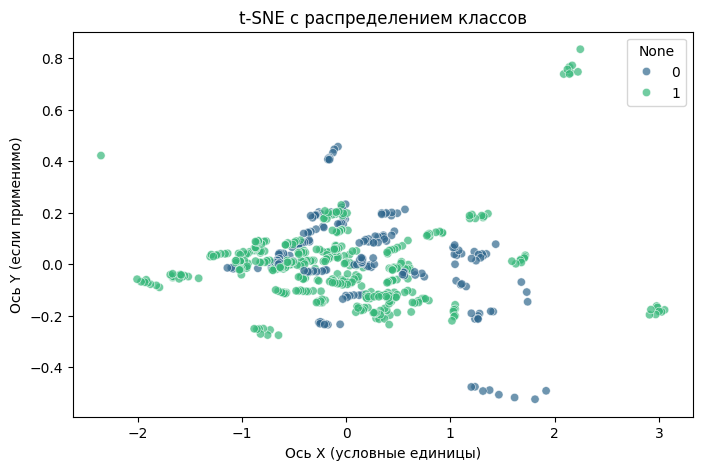

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Предполагаем, что tsne_results — результаты t-SNE (2D массив), y_train_noaug — метки
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=X_train_noaug_1[0],  # Ось X t-SNE
    y=X_train_noaug_1[1],  # Ось Y t-SNE (если есть)
    hue=y_train_noaug,
    palette="viridis",
    alpha=0.7
)
plt.title("t-SNE с распределением классов")
plt.xlabel("Ось X (условные единицы)")
plt.ylabel("Ось Y (если применимо)")
plt.show()

In [ ]:
first = True
count = 0
for x in X_train.index[0:4]:
    if first:
        plt.plot([int(val[1:]) for val in X_train.columns], X_train.loc[x])
        first = False
    else:
        plt.plot([int(val[1:]) for val in X_train.columns], X_train.loc[x], linestyle='--')
    count += 1
plt.legend(["Исходный спектр"] + ["Аугментированный спектр"] * (count-1))
plt.xlabel("Длина волны")
plt.ylabel("Интенсивность, отн. ед.")


## Обучение моделей машинного обучения

Функция отрисовки ROC кривой

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import rcParams

def draw_roc_curve(y_true: np.ndarray, 
                   proba_all: list, 
                   y_pred_all: list, 
                   names: list,
                   figsize=(10, 8),
                   linewidth=2,
                   diagonal_alpha=0.5,
                   style='ggplot',
                   palette='viridis'):
    """
    Улучшенная визуализация ROC-кривых для нескольких моделей
    
    Параметры:
    ----------
    y_true : np.ndarray
        Истинные метки классов (1D массив)
    proba_all : list
        Список предсказанных вероятностей для положительного класса
    y_pred_all : list
        Список предсказанных классов
    names : list
        Названия моделей (для легенды)
    figsize : tuple
        Размер графика (ширина, высота)
    linewidth : int
        Толщина линий ROC-кривых
    diagonal_alpha : float
        Прозрачность диагональной пунктирной линии
    style : str
        Стиль matplotlib (доступные: 'ggplot', 'seaborn', 'default' и др.)
    palette : str
        Название цветовой палитры ('viridis', 'plasma', 'tab10' и др.)
    """
    
    # Проверка доступных стилей
    available_styles = plt.style.available
    if style not in available_styles:
        print(f"Стиль '{style}' недоступен. Используются стандартные настройки.")
        print(f"Доступные стили: {available_styles}")
        style = 'default'
    
    # Применение стиля
    plt.style.use(style)
    
    # Настройка параметров
    rcParams.update({
        'axes.titlesize': 20,
        'axes.labelsize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 14,
        'grid.alpha': 0.3
    })
    
    # Создание фигуры
    fig, ax = plt.subplots(figsize=figsize)
    
    # Диагональная линия (random classifier)
    ax.plot([0, 1], [0, 1], 
            linestyle='--', 
            color='gray', 
            alpha=diagonal_alpha,
            label='Случайный классификатор (AUC = 0.5)')
    
    # Получение цветов из палитры
    # colors = plt.get_cmap(palette, len(names))
    colors = [
    "#E6194B",  # Красный
    "#3CB44B",  # Зелёный
    "#4363D8",  # Синий
    "#FFE119",  # Жёлтый
    "#F032E6",  # Пурпурный
    "#42D4F4"   # Голубой
]
    
    # Построение ROC-кривых для каждой модели
    for i, (proba, y_pred, name) in enumerate(zip(proba_all, y_pred_all, names)):
        auc_score = roc_auc_score(y_true, proba)
        fpr, tpr, _ = roc_curve(y_true, proba, pos_label=1)
        
        ax.plot(fpr, tpr, 
                linewidth=linewidth,
                color=colors[i],
                label=f'{name} (AUC = {auc_score:.3f})')
    
    # Настройка отображения
    ax.set_title('ROC-кривые моделей', pad=20)
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(True)
    ax.legend(frameon=True, framealpha=0.9, fontsize=16)
    
    # Добавление информации о данных
    # ax.annotate(f'Общее количество: {len(y_true)}\nПоложительный класс: {sum(y_true)}\nОтрицательный класс: {len(y_true)-sum(y_true)}',
    #             xy=(0.98, 0.02), 
    #             xycoords='axes fraction',
    #             ha='right', 
    #             va='bottom',
    #             fontsize=12,
    #             bbox=dict(boxstyle='round', alpha=0.2))
    
    # Установка границ
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    # Улучшенное отображение
    plt.tight_layout()
    plt.show()

Функция для вывод основных метрик

In [10]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix
def print_metrics(y_true, y_pred, name: "Undefined"):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n_bootstraps = 1000
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'specificity': []
    }

    for _ in range(n_bootstraps):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        tn, fp, fn, tp = confusion_matrix(y_true_boot, y_pred_boot).ravel()
        metrics['accuracy'].append(accuracy_score(y_true_boot, y_pred_boot))
        metrics['precision'].append(precision_score(y_true_boot, y_pred_boot, zero_division=0))
        metrics['recall'].append(recall_score(y_true_boot, y_pred_boot, zero_division=0))
        metrics['specificity'].append(tn / (tn+fp))

    # Стандартное отклонение
    std_dev = {key: np.std(values) for key, values in metrics.items()}
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"{name} classifier:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f} ± {std_dev['accuracy']:.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f} ± {std_dev['precision']:.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f} ± {std_dev['recall']:.2f}")
    print(f"Specificity: {tn / (tn+fp):.2f} ± {std_dev['specificity']:.2f}")
    print("-" * 50)

Функция для тренировки моделей с sklearn

In [11]:
from copy import deepcopy
def train_clf(clf, X_train_noaug_,
                  y_train_noaug_,
                  X_test_, 
                  y_test_,
                  X_train_=None, 
                  y_train_=None,
                  aug=True):

    proba_all = []
    y_pred_all = []
    names = []
    clf_aug = deepcopy(clf)
    if aug:
        clf_aug.fit(X_train_, y_train_)
        y_pred = clf_aug.predict(X_test_)
        proba = clf_aug.predict_proba(X_test_)[:, 1]
        proba_all.append(proba)
        y_pred_all.append(y_pred)
        names.append( f"{clf_aug.__class__.__name__} with aug")
        print_metrics(y_test_, y_pred, f"{clf.__class__.__name__} with aug")

    clf.fit(X_train_noaug_, y_train_noaug_)
    y_pred = clf.predict(X_test_)
    proba = clf.predict_proba(X_test_)[:, 1]
    proba_all.append(proba)
    y_pred_all.append(y_pred)
    names.append(clf.__class__.__name__)
    print_metrics(y_test_, y_pred, clf.__class__.__name__)
    
    return proba_all, y_pred_all, names, clf_aug, clf

In [12]:
proba_all = []
y_pred_all = []
names = []

SVM

In [33]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear', l1_ratio=0.5)
proba, y_pred, name, clf_log_aug, clf_log = train_clf(clf_log, X_train_noaug, y_train_noaug, X_val, y_val, X_train, y_train, aug=False)


c:\Users\nikba\.vscode\Projects\Scientific_work\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


LogisticRegression classifier:
Accuracy: 0.75 ± 0.03
Precision: 0.82 ± 0.03
Recall: 0.81 ± 0.03
Specificity: 0.62 ± 0.06
--------------------------------------------------


In [35]:
coef_dict

{401: 0.0,
 403: 0.0,
 405: 0.0,
 407: 0.0,
 409: 0.0,
 410: 0.0,
 412: 0.0,
 414: 0.0,
 416: 0.0,
 418: 0.0,
 420: 0.0,
 421: 0.0,
 423: -2.563250120125897,
 425: 0.0,
 427: 0.0,
 429: -1.8508218111645487,
 431: -6.783899189298643,
 433: 0.0,
 434: 0.0,
 436: 0.0,
 438: 0.0,
 440: 0.0,
 442: 0.0,
 444: 0.0,
 445: 0.0,
 447: 0.0,
 449: 0.0,
 451: 0.0,
 453: 0.0,
 455: 0.0,
 457: 0.0,
 458: 0.0,
 460: 0.0,
 462: 0.0,
 464: 0.0,
 466: 0.0,
 468: 0.0,
 470: 0.0,
 471: 0.0,
 473: 0.0,
 475: 0.0,
 477: 0.0,
 479: 0.0,
 481: 0.0,
 483: 0.0,
 485: 0.0,
 486: 0.0,
 488: 0.0,
 490: 0.0,
 492: 0.0,
 494: 0.0,
 496: 0.0,
 498: 0.0,
 499: 0.0,
 501: 0.0,
 503: 0.0,
 505: 0.0,
 507: 0.0,
 509: 0.0,
 511: 0.0,
 513: 0.0,
 514: 0.0,
 516: 0.0,
 518: 0.0,
 520: 0.0,
 522: 0.0,
 524: 0.0,
 526: 0.0,
 528: 0.0,
 530: 0.0,
 531: 0.0,
 533: 0.0,
 535: 0.0,
 537: 0.0,
 539: 0.0,
 541: 0.0,
 543: 0.0,
 545: 0.0,
 546: 0.0,
 548: 0.0,
 550: 0.0,
 552: 0.0,
 554: 0.0,
 556: 0.0,
 558: 0.0,
 560: 0.0,
 562: 0.

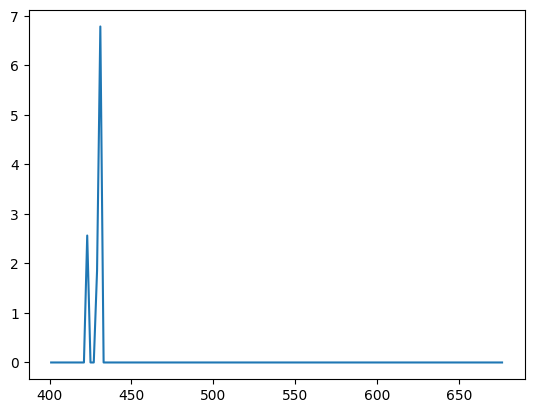

In [34]:
wave = df_raw.columns[:147].astype(int).to_list()
coef_dict = {key: float(val) for key, val in zip(wave, clf_log.coef_[0])}
plt.plot(coef_dict.keys(), np.abs(np.array(list(coef_dict.values()))))

In [ ]:
from sklearn.svm import SVC
clf_svc = SVC(class_weight="balanced", probability=True, kernel="poly", gamma="scale", random_state=42, tol=0.001, C=10, )
proba, y_pred, name, clf_svc_aug, clf_svc = train_clf(clf_svc, X_train_noaug, y_train_noaug, X_val, y_val, X_train, y_train, aug=False)
proba_all += [proba]
y_pred_all += [y_pred]
names += [name]

SVC classifier:
Accuracy: 0.84 ± 0.03
Precision: 0.90 ± 0.03
Recall: 0.87 ± 0.03
Specificity: 0.80 ± 0.05
--------------------------------------------------


In [167]:
names.append(name[1])
proba_all.append(proba[1])
preds_all.append(y_pred[1])

In [ ]:
y_pred = clf_svc.predict(X_test)
print_metrics(y_test, y_pred, "SVC")

SVC classifier:
Accuracy: 0.77
Precision: 0.80
Recall: 0.88
Specificity: 0.53
--------------------------------------------------


In [ ]:
print(f"train: {y_train_noaug.index.get_level_values(1).unique().__len__()}\n", y_train_noaug.index.get_level_values(1).unique())
print(f"val: {y_val.index.get_level_values(1).unique().__len__()}\n", y_val.index.get_level_values(1).unique())
print(f"test: {y_test.index.get_level_values(1).unique().__len__()}\n", y_test.index.get_level_values(1).unique())

train: 55
 Index(['БП035', 'БП031', 'C491223', 'БП011', 'БП036', 'C197023', 'AK1715123',
       'БП029', 'C171423', 'AK3086723', 'БП032', 'БП022', '1853122', 'CG1',
       'БП024', 'CG10', 'БП002', 'C345723', 'CG3', 'CG15', 'КОНТРОЛЬ-2',
       'C177623', 'БП004', 'КОНТРОЛЬ-4', 'БП037', 'AK2669623', 'БП028',
       'БП006', 'БП003', 'AK3097023', 'БП010', 'CG16', 'CG2', 'БП025', 'CG4',
       'CG9', 'CG17', 'CG20', 'C369723', 'CG11', 'БП014', 'C494723', 'БП007',
       'БП034', 'CG7', 'БП018', 'CG8', 'БП017', 'БП012', 'C161823', 'C192923',
       'КОНТРОЛЬ-1', 'C374523', 'C480823', 'C160223'],
      dtype='object', name='IDcard')
val: 19
 Index(['БП001', 'БП026', 'C148823', 'БП013', 'C366223', 'C486723', 'БП021',
       'CG19', 'CG13', 'БП030', 'C350723', 'C595023', 'БП027', 'CG18', 'БП016',
       'БП020', 'C367523', 'AK1211723', 'C497223'],
      dtype='object', name='IDcard')
test: 19
 Index(['C486523', 'CG5', 'C497623', 'AK2531823', 'CG12', 'CG14', 'C388923',
       'C196423', 'C196

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
clf_svc = SVC(class_weight="balanced", probability=True, gamma="scale", random_state=42, tol=0.0001)
params = {
    "kernel": ["poly"],
    "C": [0.1, 1., 5., 10., 50., 100., 200.],
}

search_clf = GridSearchCV(estimator=clf_svc,
                          param_grid=params,
                          scoring="roc_auc",
                          cv=5,
                          n_jobs=-1)
search_clf.fit(X_train, y_train)
y_pred = search_clf.predict(X_val)
print(search_clf.best_params_)
print_metrics(y_pred, y_val, "SVC")

{'C': 10.0, 'kernel': 'poly'}
SVC classifier:
Accuracy: 0.81
Precision: 0.82
Recall: 0.90
--------------------------------------------------


RandomForest

In [23]:
from sklearn.ensemble import RandomForestClassifier

params = {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 19, 'n_estimators': 483}
# clf_rf = RandomForestClassifier(n_estimators=500, 
#                                 class_weight="balanced", 
#                                 max_depth=10, 
#                                 min_samples_leaf=10, 
#                                 max_features='sqrt',
#                                 min_samples_split=15, 
#                                 criterion='entropy',
#                                 random_state=42)
clf_rf = RandomForestClassifier(**params)
proba, y_pred, name, clf_rf_aug, clf_rf = train_clf(clf_rf, X_train_noaug, y_train_noaug, X_val, y_val, X_train, y_train, aug=False)
proba_all += proba
y_pred_all += y_pred
names += name

RandomForestClassifier classifier:
Accuracy: 0.81 ± 0.03
Precision: 0.82 ± 0.03
Recall: 0.94 ± 0.02
Specificity: 0.55 ± 0.06
--------------------------------------------------


In [ ]:
y_pred = clf_rf.predict(X_test)
print_metrics(y_test, y_pred, "RandomForest")

RandomForest classifier:
Accuracy: 0.57
Precision: 0.67
Recall: 0.72
Specificity: 0.25
--------------------------------------------------


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': [500],          # Количество деревьев
    'max_depth': list(range(5, 10)),   # Глубина деревьев
    'max_features': ['sqrt', 'log2', None],     # Количество признаков для разделения
    'min_samples_split': randint(2, 20),        # Минимальное количество образцов для разделения узла
    'min_samples_leaf': randint(1, 10),         # Минимальное количество образцов в листе
    'criterion': ['gini', 'entropy'],           # Критерий разделения
}

# Создание модели
rf = RandomForestClassifier(random_state=42)

# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                  # Количество итераций поиска
    cv=3,                        # Количество фолдов кросс-валидации
    scoring='roc_auc',       # Метрика для оптимизации
    n_jobs=-1,                   # Использовать все ядра процессора
    verbose=1,                   # Вывод прогресса
    random_state=42
)

# Обучение модели
random_search.fit(X_train_noaug, y_train_noaug)
y_pred = random_search.predict(X_val)
print(random_search.best_params_)
print_metrics(y_pred, y_val, "RandomForest")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 19, 'n_estimators': 483}
RandomForest classifier:
Accuracy: 0.82
Precision: 0.97
Recall: 0.81
--------------------------------------------------


In [ ]:
y_pred = random_search.predict(X_val)
print(random_search.best_params_)
print_metrics(y_val, y_pred, "RandomForest")

{'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS', 'border_count': 179, 'depth': 6, 'grow_policy': 'SymmetricTree', 'iterations': 927, 'l2_leaf_reg': np.float64(0.9413996499504883), 'learning_rate': np.float64(0.04948861422838413), 'min_data_in_leaf': 6, 'random_strength': np.float64(0.6689882547142286)}
RandomForest classifier:
Accuracy: 0.78
Precision: 0.81
Recall: 0.88
--------------------------------------------------


In [ ]:
best_params = {'criterion': 'entropy', 'oob_score': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 500}
clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced', **best_params)
proba, y_pred, name = train_clf(clf_rf, X_train_noaug, y_train_noaug, X_val, y_val, X_train, y_train)
proba_all += proba
y_pred_all += y_pred
names += name

RandomForestClassifier with aug classifier:
Accuracy: 0.82
Precision: 0.87
Recall: 0.88
--------------------------------------------------
RandomForestClassifier classifier:
Accuracy: 0.76
Precision: 0.82
Recall: 0.83
--------------------------------------------------


GradientBoosting

In [ ]:
from catboost import CatBoostClassifier

param_dict = {
    'iterations': 2000,
    'max_depth': 5,
    'l2_leaf_reg': 10.0,
    'random_strength': 0.5,
    'border_count': 128,
    'min_data_in_leaf': 15,
    'auto_class_weights': 'Balanced'
}

clf_cat = CatBoostClassifier(verbose=0, random_seed=42, **param_dict)
proba, y_pred, name, clf_cat_aug, clf_cat = train_clf(clf_cat, X_train_noaug, y_train_noaug, X_val, y_val, X_train, y_train)
# proba_all += proba
# y_pred_all += y_pred
# names += name

In [ ]:
y_pred = clf_cat.predict(X_test)
print_metrics(y_test, y_pred, "GradientBoosting")

GradientBoosting classifier:
Accuracy: 0.56
Precision: 0.67
Recall: 0.69
--------------------------------------------------


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from scipy.stats import randint, uniform
from tqdm import tqdm
from time import perf_counter
from sklearn.utils import parallel_backend
# Определение пространства параметров
param_dist = {
    'iterations': randint(300, 1500),
    'learning_rate': uniform(0.001, 0.3),  # log-uniform distribution
    'depth': randint(5, 8),
    'l2_leaf_reg': uniform(0.1, 10.0),
    'random_strength': uniform(0.0, 1.0),
    'border_count': randint(32, 255),
    'min_data_in_leaf': randint(1, 20),
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'auto_class_weights': ['Balanced']
}

# Создание модели с отключенным выводом (verbose=False)
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

# Настройка кросс-валидации (стратифицированная)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Определение метрики (F1 weighted)

# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=30,  # Количество итераций
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,  # Использовать все ядра
    verbose=1,
    random_state=42,
    return_train_score=True
)


random_search.fit(X_train_noaug, y_train_noaug)
y_pred = random_search.predict(X_val)
print(random_search.best_params_)
print_metrics(y_pred, y_val, "CatBoost")
# # Запуск поиска (предполагаем, что X_train и y_train уже определены)
# random_search.fit(X_train, y_train)  # Укажите индексы категориальных признаков

Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'auto_class_weights': 'Balanced', 'bootstrap_type': 'MVS', 'border_count': 179, 'depth': 6, 'grow_policy': 'SymmetricTree', 'iterations': 927, 'l2_leaf_reg': np.float64(0.9413996499504883), 'learning_rate': np.float64(0.04948861422838413), 'min_data_in_leaf': 6, 'random_strength': np.float64(0.6689882547142286)}
CatBoost classifier:
Accuracy: 0.78
Precision: 0.88
Recall: 0.81
--------------------------------------------------


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000)
proba, y_pred, name, clf_gb_aug, clf_gb = train_clf(clf_gb, X_train_noaug, y_train_noaug, X_val, y_val, X_train, y_train, aug=False)

GradientBoostingClassifier classifier:
Accuracy: 0.80 ± 0.03
Precision: 0.81 ± 0.03
Recall: 0.92 ± 0.02
Specificity: 0.55 ± 0.06
--------------------------------------------------


In [26]:
proba_all += proba
y_pred_all += y_pred
names += name

In [ ]:
y_pred = clf_gb.predict(X_test)
print_metrics(y_test, y_pred, "GradientBoosting")

GradientBoosting classifier:
Accuracy: 0.56
Precision: 0.66
Recall: 0.71
--------------------------------------------------


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
# Определение пространства параметров
xgb_params = {
    # Основные параметры
    'n_estimators': [200, 500, 1000, 1500],  # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Скорость обучения (eta)
    
    # Параметры деревьев
    'max_depth': [3, 5, 7, 9],  # Максимальная глубина
    'min_child_weight': [1, 3, 5],  # Минимальная сумма весов в листе
    'gamma': [0, 0.1, 0.2, 0.3],  # Минимальное уменьшение потерь для split
    
    # Регуляризация
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1-регуляризация (alpha)
    'reg_lambda': [0, 0.1, 0.5, 1, 2],  # L2-регуляризация (lambda)
    
    # Сэмплирование данных и признаков
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Доля строк для обучения дерева
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Доля признаков для дерева
    
    # Параметры для DART (если booster='dart')
    'sample_type': ['uniform', 'weighted'],
    'normalize_type': ['tree', 'forest'],
    'rate_drop': [0.1, 0.2, 0.3],
    
    # Параметры задачи
    'scale_pos_weight': [1, 2, 5]  # Балансировка классов (если дисбаланс)
}

# Создание модели с отключенным выводом (verbose=False)
xgb_model = XGBClassifier(random_state=42)

# Настройка кросс-валидации (стратифицированная)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Определение метрики (F1 weighted)

# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=50,  # Количество итераций
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,  # Использовать все ядра
    verbose=1,
    random_state=42,
    return_train_score=True
)


random_search.fit(X_train_noaug, y_train_noaug)
y_pred = random_search.predict(X_val)
print(random_search.best_params_)
print_metrics(y_pred, y_val, "XGB")
# # Запуск поиска (предполагаем, что X_train и y_train уже определены)
# random_search.fit(X_train, y_train)  # Укажите индексы категориальных признаков

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'subsample': 0.8, 'scale_pos_weight': 2, 'sample_type': 'uniform', 'reg_lambda': 0, 'reg_alpha': 0.1, 'rate_drop': 0.3, 'random_state': 42, 'objective': 'binary:logistic', 'normalize_type': 'tree', 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.3, 'eval_metric': 'logloss', 'colsample_bytree': 0.6, 'booster': 'gbtree'}
XGB classifier:
Accuracy: 0.77
Precision: 0.88
Recall: 0.80
--------------------------------------------------


In [ ]:
y_pred = random_search.predict(X_test)
print_metrics(y_test, y_pred, "XGB")

XGB classifier:
Accuracy: 0.61
Precision: 0.69
Recall: 0.79
--------------------------------------------------


In [ ]:
from xgboost import XGBClassifier
params_xgb = {'subsample': 0.8, 
              'scale_pos_weight': 2.1, 
              'reg_lambda': 10., 
              'reg_alpha': 0.5, 
              'random_state': 42, 
              'objective': 'binary:logistic', 
              'n_estimators': 200, 
              'min_child_weight': 3, 
              'max_depth': 7, 
              'learning_rate': 0.3, 
              'gamma': 0.3, 
              'eval_metric': 'logloss', 
              'colsample_bytree': 0.6, 
              'booster': 'gbtree'}
clf_xgb = XGBClassifier(**random_search.best_params_)
proba, y_pred, name, clf_xgb_aug, clf_xgb = train_clf(clf_xgb, X_train_noaug, y_train_noaug, X_val, y_val, X_train, y_train)

XGBClassifier with aug classifier:
Accuracy: 0.71
Precision: 0.77
Recall: 0.82
--------------------------------------------------
XGBClassifier classifier:
Accuracy: 0.77
Precision: 0.80
Recall: 0.88
--------------------------------------------------


In [ ]:
y_pred = clf_xgb.predict(X_test)
print_metrics(y_test, y_pred, name="XGB")

XGB classifier:
Accuracy: 0.61
Precision: 0.69
Recall: 0.79
--------------------------------------------------


In [ ]:
clf_cat = CatBoostClassifier(verbose=0, random_state=42, **random_search.best_params_)
proba, y_pred, name, clf_cat_aug, clf_cat = train_clf(clf_cat, X_train_noaug, y_train_noaug, X_val, y_val, X_train, y_train)
# proba_all += proba
# y_pred_all += y_pred
# names += name

CatBoostClassifier with aug classifier:
Accuracy: 0.73
Precision: 0.80
Recall: 0.80
--------------------------------------------------
CatBoostClassifier classifier:
Accuracy: 0.78
Precision: 0.81
Recall: 0.88
--------------------------------------------------


In [108]:
names

['SVC with aug',
 'SVC',
 'RandomForestClassifier with aug',
 'RandomForestClassifier',
 'GradientBoostingClassifier with aug',
 'GradientBoostingClassifier']

In [27]:
names = names[0] + names[1:]
y_pred_all = y_pred_all[0] + y_pred_all[1:]
proba_all = proba_all[0] + proba_all[1:]

In [29]:
names[0] = "SVM"

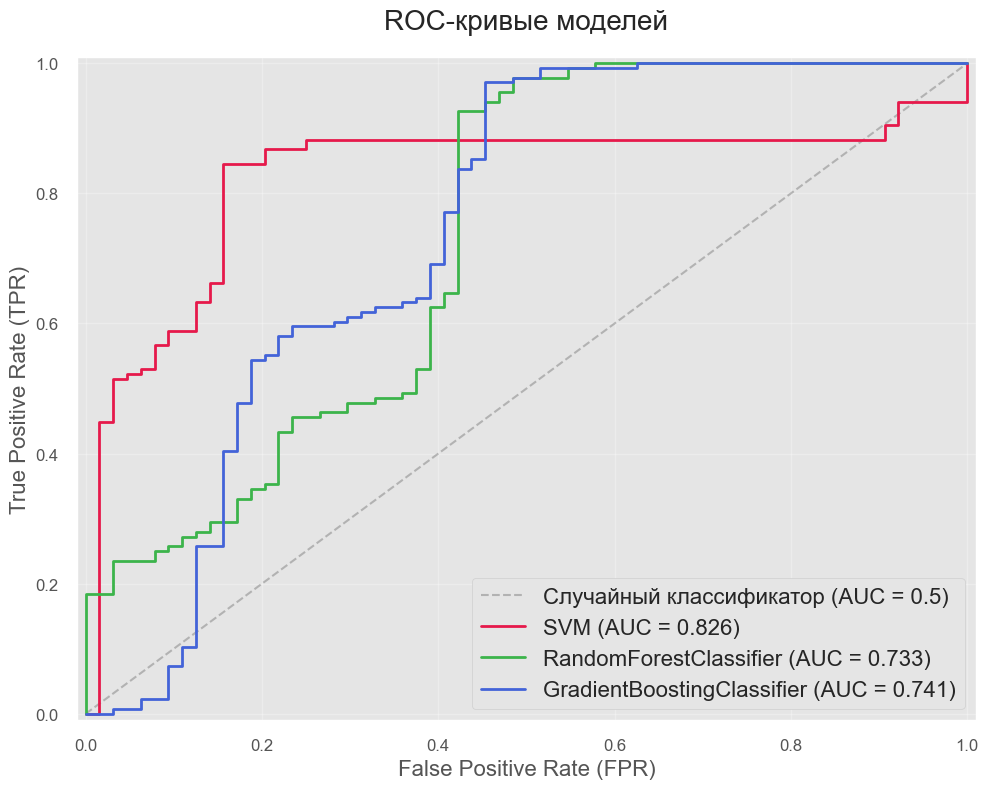

In [32]:
draw_roc_curve(y_val, proba_all, y_pred_all, names)

In [110]:
names = ["SVM с аугментациями", "SVM", "Random Forest с аугментациями", "Random Forest", "GradientBoosting с аугментациями", "GradientBoosting"]

## Глубокое обучение

Создание даталоадеров

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
def create_default_dataloader(X: pd.DataFrame, y: pd.Series, batch_size: int=32, shuffle: bool=True, worker_seed=42) -> DataLoader:

    labels = torch.tensor(y.to_numpy().reshape(-1,))
    data = torch.tensor(X.to_numpy(), dtype=torch.float)

    dataset = TensorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, worker_init_fn=worker_seed)
    return dataloader

In [35]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import check_random_state

class FluorescenceSpectraDataset(Dataset):
    def __init__(self, data, target_column=None, augmentation=False, 
                 augmentation_params=None, random_state=None):
        """
        Custom Dataset for fluorescence spectra with built-in augmentation.
        
        Args:
            data: Input data (numpy array or pandas DataFrame)
            target_column: Name of target column (if data is DataFrame)
            augmentation: Whether to apply augmentation
            augmentation_params: Parameters for augmentation
                - augment_prob: probability of applying augmentation (default: 0.5)
                - noise_scale: scale of Gaussian noise (default: 0.01)
                - stretch_range: range for random stretching (default: (0.95, 1.05))
                - shift_range: range for random shifting (default: (-0.05, 0.05))
            random_state: Random seed for reproducibility
        """
        self.augmentation = augmentation
        self.rng = check_random_state(random_state)
        
        if isinstance(data, pd.DataFrame):
            if target_column is None:
                raise ValueError("target_column must be specified for DataFrame input")
            self.X = data.drop(columns=[target_column]).values
            self.y = data[target_column].values
            self.columns = data.columns.tolist()
        else:
            self.X = data
            self.y = None
            self.columns = None
        
        # Set default augmentation parameters
        self.aug_params = {
            'augment_prob': 0.5,
            'noise_scale': 0.01,
            'stretch_range': (0.95, 1.05),
            'shift_range': (-0.05, 0.05),
            **({} if augmentation_params is None else augmentation_params)
        }
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        spectrum = self.X[idx].astype(np.float32)
        target = self.y[idx] if self.y is not None else -1
        
        if self.augmentation and self.rng.rand() < self.aug_params['augment_prob']:
            # Apply random stretching
            stretch_factor = self.rng.uniform(*self.aug_params['stretch_range'])
            x_original = np.arange(len(spectrum))
            x_new = np.linspace(0, len(spectrum), int(len(spectrum) * stretch_factor))
            spectrum = np.interp(x_new, x_original, spectrum)
            
            # Apply random shifting
            shift = self.rng.uniform(*self.aug_params['shift_range'])
            spectrum = spectrum * (1 + shift)
            
            # Add Gaussian noise
            noise = self.rng.normal(0, self.aug_params['noise_scale'], len(spectrum))
            spectrum = spectrum + noise
            
            # Normalize to original range if needed
            spectrum = np.clip(spectrum, 0, None)  # assuming non-negative spectra
            
            # Resample back to original length if stretching changed it
            if len(spectrum) != len(self.X[idx]):
                spectrum = np.interp(
                    np.linspace(0, len(spectrum)-1, len(self.X[idx])),
                    np.arange(len(spectrum)),
                    spectrum
                )
        
        # Convert to torch tensors
        spectrum_tensor = torch.FloatTensor(spectrum)
        target_tensor = torch.LongTensor([target]) if self.y is not None else torch.Tensor([-1])
        
        return spectrum_tensor, target_tensor


class FluorescenceDataLoader(DataLoader):
    def __init__(self, data, target_column=None, batch_size=32, shuffle=True, 
                 augmentation=False, augmentation_params=None, random_state=None, **kwargs):
        """
        Custom DataLoader for fluorescence spectra with built-in augmentation.
        
        Args:
            data: Input data (numpy array or pandas DataFrame)
            target_column: Name of target column (if data is DataFrame)
            batch_size: Number of samples per batch
            shuffle: Whether to shuffle the data
            augmentation: Whether to apply augmentation
            augmentation_params: Parameters for augmentation
            random_state: Random seed for reproducibility
            **kwargs: Additional arguments for DataLoader
        """
        dataset = FluorescenceSpectraDataset(
            data=data,
            target_column=target_column,
            augmentation=augmentation,
            augmentation_params=augmentation_params,
            random_state=random_state
        )
        
        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            **kwargs
        )

### Модели

FCNN

In [36]:
import random
class SpectralClassifierFCNN(nn.Module):
    def __init__(self, 
                 in_dim=147, 
                 hidden_dims=[256, 128, 64], 
                 out_dim=1, 
                 activation="leaky_relu", 
                 dropout_rate=0.3, 
                 random_seed=None):
        super().__init__()
        
        activations = {
            "leaky_relu": nn.LeakyReLU(0.2),
            "relu": nn.ReLU(),
            "selu": nn.SELU(),
            "gelu": nn.GELU(),
            "sigmoid": nn.Sigmoid(),
            "silu": nn.SiLU()
        }
        if random_seed is not None:
            self.set_seed(random_seed) 
        
        self.first_block = nn.Sequential(
            nn.Linear(in_dim, hidden_dims[0]),
            nn.LayerNorm(hidden_dims[0]),
            nn.Dropout(dropout_rate),
            activations[activation]
        )
        
        self.hidden_blocks = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            block = nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.LayerNorm(hidden_dims[i+1]),
                nn.Dropout(dropout_rate),
                activations[activation]
            )
            self.hidden_blocks.append(block)
        
        self.output = nn.Sequential(
            nn.Linear(hidden_dims[-1], out_dim),
        )

        self._init_weights()

    def set_seed(self, seed=42):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    def predict(self, val_dataloader):
        if isinstance(val_dataloader, DataLoader):
            pass
        elif isinstance(val_dataloader, TensorDataset):
            val_dataloader = DataLoader(val_dataloader, 
                                        batch_size=64, 
                                        shuffle=False)
                
        device = "cuda" \
            if next(self.parameters()).is_cuda \
            else "cpu"
        self.to(device)
        self.eval()
        preds_all = np.array([])
        proba_all = np.array([])
        labels_all = np.array([])
        for batch, labels in val_dataloader:
            with torch.no_grad():
                batch = batch.to(torch.float)
                logits = self(batch.to(device)).squeeze().to(torch.float)
                proba = torch.sigmoid(logits)
                preds = (proba > 0.5).to(torch.int)

                preds_all = np.concatenate((preds_all, 
                                            preds.detach().cpu().numpy()))
                labels_all = np.concatenate((labels_all, 
                                             labels.detach().cpu().numpy()))
                proba_all = np.concatenate((proba_all, 
                                            proba.detach().cpu().numpy()))

        return preds_all, proba_all, labels_all
    def create_default_dataloader(self, 
                                  X: pd.DataFrame, 
                                  y: pd.Series, 
                                  batch_size: int=32, 
                                  shuffle: bool=True, 
                                  worker_seed=42) -> DataLoader:

        labels = torch.tensor(y.to_numpy())
        data = torch.tensor(X.to_numpy(), dtype=torch.float)

        dataset = TensorDataset(data, labels)
        dataloader = DataLoader(dataset, 
                                batch_size=batch_size, 
                                shuffle=shuffle, 
                                worker_init_fn=worker_seed)
        return dataloader
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, 
                                        mode='fan_out', 
                                        nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.first_block(x)
        for block in self.hidden_blocks:
            residual = x
            x = block(x)
            if x.shape == residual.shape:
                x = x + residual
        return self.output(x)

Transformer

In [37]:
import torch
import torch.nn as nn
import math

class SpectralTransformer(nn.Module):
    def __init__(self, in_dim, 
                 num_classes, 
                 num_heads=8, 
                 num_layers=4, 
                 hidden_dim=256, 
                 patch_size=32, 
                 dropout=0.1, 
                 seed=None):
        super().__init__()
        

        if seed is not None:
            self.set_seed(seed)
        self.patch_size = patch_size
        self.num_patches = math.ceil(in_dim / patch_size)
        
        self.patch_embedding = nn.Linear(patch_size, 
                                         hidden_dim)
        self.position_emb = nn.Parameter(torch.randn(1, 
                                                     self.num_patches, 
                                                     hidden_dim))
        

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, 
                                                 num_layers)

        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def set_seed(self, seed=42):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    def forward(self, x):

        if x.size(1) % self.patch_size != 0:
            pad_size = self.patch_size -\
                  (x.size(1) % self.patch_size)
            x = torch.cat([x, 
                           torch.zeros(x.size(0), 
                                       pad_size)], dim=1)

        x = x.view(x.size(0), 
                   self.num_patches, 
                   self.patch_size)
        
        x = self.patch_embedding(x) + self.position_emb

        x = self.transformer(x)

        x = x.mean(dim=1)
        
        return self.classifier(x)

1D CNN

In [38]:
class CNN1DSpectrum(nn.Module):
    def __init__(self, 
                 in_channels: int = 1,          
                 hidden_dims: list = [32, 64, 128],
                 kernel_sizes: list = [5, 3, 3],  
                 activation: str = "gelu",
                 dropout_rate: float = 0.2,
                 use_residual: bool = True,
                 random_seed: int = None):
        
        super().__init__()
        

        assert len(hidden_dims) ==\
            len(kernel_sizes), "Количество слоёв и ядер должно совпадать"
        if random_seed is not None:
            self.set_seed(random_seed)
        activations = {
            "relu": nn.ReLU(),
            "leaky_relu": nn.LeakyReLU(0.1),
            "gelu": nn.GELU(),
            "selu": nn.SELU()
        }
        assert activation in activations, f"Активация {activation} не поддерживается"
        
        self.blocks = nn.ModuleList()
        self.proj_layers = nn.ModuleList()
        prev_channels = in_channels
        

        for i, (filters, kernel) in enumerate(zip(hidden_dims, 
                                                  kernel_sizes)):
            block = nn.Sequential(
                nn.Conv1d(
                    in_channels=prev_channels,
                    out_channels=filters,
                    kernel_size=kernel,
                    padding=kernel // 2,
                    stride=1
                ),
                nn.BatchNorm1d(filters),
                nn.Dropout(dropout_rate),
                activations[activation]
            )
            self.blocks.append(block)
            
            if use_residual and prev_channels != filters:
                self.proj_layers.append(nn.Conv1d(prev_channels, 
                                                  filters, 
                                                  kernel_size=1))
            else:
                self.proj_layers.append(nn.Identity())
                
            prev_channels = filters

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_dims[-1], 1)
            )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, 
                                        mode='fan_out', 
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    def set_seed(self, seed=42):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    def forward(self, x):
        x = x.unsqueeze(1)
        
        for i, block in enumerate(self.blocks):
            residual = x
            x = block(x)
            if self.proj_layers[i] is not None:
                residual = self.proj_layers[i](residual)
                x = x + residual
                
        x = self.adaptive_pool(x)
        return self.output(x)

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/nikba/Downloads/windows_10_cmake_Release_Graphviz-12.2.1-win64/Graphviz-12.2.1-win64/bin'  # Укажите ваш путь

In [ ]:
model = SpectralClassifierFCNN()
y = model(torch.tensor(X_train_noaug.to_numpy(), dtype=torch.float))

# Визуализируем
make_dot(y, params=dict(model.named_parameters())).render("torch_model", format="png")

'torch_model.png'

### Функции для тренировки

Focal Loss

In [39]:
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, 
                                                      targets, 
                                                      reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

Функция train

In [40]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
def train(model, epochs, 
          optim, criterion, 
          train_dataloader, val_dataloader, 
          scheduler=None, logging=False, 
          tqdm_desc="Processed") -> tuple:
    losses_train = []
    losses_val = []
    acc = []
    precision = []
    recall = []
    specificity = []
    device = "cuda" if next(model.parameters()).is_cuda else "cpu"
    for epoch in tqdm(range(epochs), 
                      desc=tqdm_desc):
        loss_train = []
        loss_val = []
        model.train()
        for batch, labels in train_dataloader:
            labels = labels.squeeze()
            optim.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs.to(torch.float).squeeze(), 
                             labels.to(torch.float))
            loss.backward()
            optim.step()

            loss_train.append(loss.detach().cpu().numpy())

        losses_train.append(
            sum(loss_train) / len(loss_train)
            )

        model.eval()
        preds_epoch = np.array([])
        labels_epoch = np.array([])
        for batch, labels in val_dataloader:
            labels = labels.squeeze()
            with torch.no_grad():
                batch = batch.to(torch.float)
                logits = model(
                    batch.to(device)
                    ).squeeze().to(torch.float)
                preds = (torch.sigmoid(logits) > 0.5).float()
                loss = criterion(logits, 
                                 labels.to(torch.float).to(device)
                                 )
                loss_val.append(loss.detach().cpu().numpy())
                preds_epoch = np.concatenate(
                    (preds_epoch, preds.detach().cpu().numpy())
                    )
                labels_epoch = np.concatenate(
                    (labels_epoch, labels.detach().cpu().numpy())
                    )

        tn, fp, fn, tp = confusion_matrix(labels_epoch, preds_epoch).ravel()
        losses_val.append(sum(loss_val) / len(loss_val))
        acc.append(accuracy_score(labels_epoch, preds_epoch))
        specificity.append(tn / (tn + fp))
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
        if scheduler != None:
            if str(scheduler.__class__) == \
                "<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>":
                scheduler.step(epoch)
            else:
                scheduler.step()


    print(f"Training complete successfully. Best accuracy on validation: {max(acc):.4f}")
    return losses_train, losses_val, acc, precision, recall, specificity

Класс HyperparameterSearch

In [41]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm

def g_mean(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return (recall * specificity) ** 0.5

class HyperparameterSearch:
    def __init__(self, model_class, 
                 param_distributions, 
                 model_params_names, 
                 n_iter=10):
        self.model_class = model_class
        self.model_params_names = model_params_names
        self.param_distributions = param_distributions
        self.n_iter = n_iter
        self.results_ = []

    def fit(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):

        train_dataset = TensorDataset(torch.FloatTensor(X_train.to_numpy()), 
                                      torch.FloatTensor(y_train.to_numpy()))
        val_dataset = TensorDataset(torch.FloatTensor(X_val.to_numpy()), 
                                    torch.FloatTensor(y_val.to_numpy()))
        

        param_list = list(ParameterSampler(self.param_distributions, 
                                           n_iter=self.n_iter))
        best_metric = 0
        for params in tqdm(param_list):

            model_params = dict([(name, params[name]) 
                                 for name in self.model_params_names])
            model = self.model_class(in_dim=X_train.shape[1], 
                                     **model_params)

            optimizer = torch.optim.AdamW(
                model.parameters(), 
                lr=params['lr'],
                weight_decay=params['weight_decay']
            )
            pos_weight = sum(y_train[y_train == 0]) / sum(y_train[y_train == 1])
            if params['loss'] == "focal":
                try:
                    gamma = params['gamma']
                except:
                    gamma = 2.0
                criterion = FocalLoss(alpha=pos_weight, gamma=gamma)
            else:
                criterion = nn.BCEWithLogitsLoss(
                    pos_weight=torch.tensor([pos_weight])
                    )
            

            train_loader = DataLoader(train_dataset, 
                                      batch_size=batch_size, 
                                      shuffle=True)
            val_loader = DataLoader(val_dataset, 
                                    batch_size=64, 
                                    shuffle=False)

                        
            losses_train, losses_val,\
                  acc, precision, recall,\
                      specificity, best_params_ = train(model, 
                                                        epochs=epochs, 
                                                        optim=optimizer, 
                                                        criterion=criterion, 
                                                        train_dataloader=train_loader, 
                                                        val_dataloader=val_loader, 
                                                        scheduler=None)

            if acc[-1] > best_metric:
                best_metric = acc[-1]
                best_params = params.copy()
                best_params['val_metric'] = best_metric
                best_params['prec'] = precision[-1]
                best_params['spec'] = specificity[-1]
                best_params['recall'] = recall[-1]
                self.results_.append(best_params)
            

        self.results_.sort(key=lambda x: x['val_metric'], reverse=True)
        return self

In [42]:
import numpy as np

def monotonicity_coefficient(sequence, trend='auto'):
    """
    Вычисляет коэффициент монотонности последовательности.
    
    Параметры:
    - sequence: list или np.array, последовательность значений.
    - trend: str, 'auto' (определяет тренд автоматически), 
             'increase' (проверяет возрастание), 
             'decrease' (проверяет убывание).
    
    Возвращает:
    - Коэффициент монотонности от 0 (не монотонна) до 1 (идеально монотонна).
    - Тренд: 'increase', 'decrease' или 'none'.
    """
    if len(sequence) <= 1:
        return 0.0, 'none'
    
    differences = np.diff(sequence)
    n = len(differences)
    
    if trend == 'auto':
        # Автоматически определяем тренд по знакам разностей
        pos = np.sum(differences >= 0)
        neg = np.sum(differences <= 0)
        
        if pos >= neg:
            trend = 'increase'
            matches = np.sum(differences >= 0)
        else:
            trend = 'decrease'
            matches = np.sum(differences <= 0)
    else:
        # Проверяем заданный тренд
        if trend == 'increase':
            matches = np.sum(differences >= 0)
        elif trend == 'decrease':
            matches = np.sum(differences <= 0)
        else:
            raise ValueError("trend должен быть 'auto', 'increase' или 'decrease'")
    
    coefficient = matches / n
    return coefficient, trend

Предсказание

In [43]:
def predict(model, val_dataloader):
    device = "cuda" if next(model.parameters()).is_cuda else "cpu"
    model.to(device)
    model.eval()
    preds_all = np.array([])
    proba_all = np.array([])
    labels_all = np.array([])
    for batch, labels in val_dataloader:
        with torch.no_grad():
            batch = batch.to(torch.float)
            logits = model(batch.to(device)).squeeze().to(torch.float)
            proba = torch.sigmoid(logits)
            preds = (proba > 0.5).to(torch.int)

            preds_all = np.concatenate((preds_all, preds.detach().cpu().numpy()))
            labels_all = np.concatenate((labels_all, labels.detach().cpu().numpy()))
            proba_all = np.concatenate((proba_all, proba.detach().cpu().numpy()))

    return preds_all, proba_all, labels_all

### Обучение модели FCNN

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

In [44]:
aug_params = {
    'augment_prob': 0.2,  # вероятность аугментации каждого образца
    'noise_scale': 0.02,
    'stretch_range': (0.99, 1.01),
    'shift_range': (-0.01, 0.01),
}

train_dataloader = FluorescenceDataLoader(
    data=df_train,
    target_column='target',
    batch_size=258,
    augmentation=True,
    augmentation_params=aug_params,
    random_state=42
)

In [45]:
train_dataloader = create_default_dataloader(X_train_noaug, y_train_noaug, batch_size=256)
val_dataloader = create_default_dataloader(X_val, y_val, batch_size=64, shuffle=False)
test_dataloader = create_default_dataloader(X_test, y_test, batch_size=64, shuffle=False)

In [46]:
params = {'weight_decay': 0.0005, 
          'pos_weight': 0.4716981132075472, 
          'lr': 0.0001,
          'hidden_dims': [128, 64], 
          'dropout_rate': 0.0, 
          'activation': 'gelu',
          'random_seed': 42,
          'loss': 'focal',
          'gamma': 2.}

In [47]:
import random
import itertools
param_distributions = {
    'hidden_dims': [[128, 64], [128, 128], [64, 64]],
    'activation': ['gelu', 'silu'],
    'dropout_rate': [0.0, 0.1, 0.3],
    'lr': [1e-4, 5e-4, 1e-3],
    'weight_decay': [0., 1e-5, 1e-4, 5e-5, 5e-4, 1e-3],
    'random_seed': [42],
    'gamma': [0., 1., 2., 3., 4.],
    'loss': ['focal']
}
def get_random_combinations(param_distributions, n_samples):
    """Генерирует n случайных уникальных комбинаций параметров"""
    keys = param_distributions.keys()
    values = param_distributions.values()
    
    # Создаем все возможные комбинации
    all_combinations = list(itertools.product(*values))
    
    # Если запрошено больше, чем есть, возвращаем все
    if n_samples >= len(all_combinations):
        return [dict(zip(keys, combo)) for combo in all_combinations]
    
    # Выбираем случайное подмножество
    random_combinations = random.sample(all_combinations, n_samples)
    return [dict(zip(keys, combo)) for combo in random_combinations]

# Пример: получить 10 случайных комбинаций
random_combinations = get_random_combinations(param_distributions, 200)

In [48]:
results_ = []
best_metric = 0
for params in random_combinations:
    in_dim = len(X_val.columns)

    # params = {'weight_decay': 0.0001, 
    #           'pos_weight': 0.4716981132075472, 
    #           'lr': 0.0005,
    #           'hidden_dims': [128, 64], 
    #           'dropout_rate': 0.0, 
    #           'activation': 'silu',
    #           'random_seed': 42,
    #           'loss': 'focal',
    #           'gamma': 2.}
    # params = {'weight_decay': 0.0,
    # 'random_seed': 42,
    # 'lr': 0.001,
    # 'loss': 'focal',
    # 'hidden_dims': [64, 64],
    # 'gamma': 1.0,
    # 'dropout_rate': 0.0,
    # 'activation': 'gelu',
    # 'val_metric': 0.68,
    # 'prec': np.float64(0.68),
    # 'spec': np.float64(0.0),
    # 'recall': np.float64(1.0)}

    model_fcnn = SpectralClassifierFCNN(
        in_dim=in_dim,
        hidden_dims=params['hidden_dims'],  # Более глубокая архитектура
        activation=params['activation'],  # Можно экспериментировать
        dropout_rate=params['dropout_rate'],
        random_seed=params['random_seed']
    )
    #model = Discriminator(len(X_val.columns), hidden_dims=[256, 128, 64], out_dim=1, activation="leaky_relu")
    # model = CNN1DSpectrum(input_length=in_dim,
    #                       in_channels=1,
    #                       hidden_dims=[4, 8, 16],
    #                       kernel_sizes=[3, 5, 7],
    #                       activation="gelu",
    #                       dropout_rate=0.3,
    #                       use_residual=True)
    optimizer = torch.optim.AdamW(
        model_fcnn.parameters(),
        lr=params['lr'],  # Уменьшенный LR
        weight_decay=params['weight_decay']  # Меньше регуляризации
    )
    
    # optimizer = torch.optim.SGD(model_fcnn.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    # Изменяем шедулер
    scheduler=None
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=0.9, step_size=15)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
    weight = len(y_train[y_train==0]) / (len(y_train[y_train==1]))
    if params['loss'] == 'focal':
        criterion = FocalLoss(alpha=weight, gamma=params['gamma'])
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

    epochs = 500
    losses_train, losses_val, acc, precision, recall, specificity, best_params = train(model_fcnn, epochs=epochs, optim=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=val_dataloader, scheduler=scheduler)


    best_metric = acc[-1]
    best_params = params.copy()
    best_params['val_metric'] = best_metric
    best_params['prec'] = precision[-1]
    best_params['spec'] = specificity[-1]
    best_params['recall'] = recall[-1]
    results_.append(best_params)
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # ax[0].plot(range(1, epochs + 1), losses_train)
    # ax[0].plot(range(1, epochs + 1), losses_val)
    # ax[0].legend(["Loss train", "Loss validation"])
    # ax[1].plot(range(1, epochs+1), acc)
    # ax[1].plot(range(1, epochs+1), precision)
    # ax[1].plot(range(1, epochs+1), recall)
    # ax[1].plot(range(1, epochs+1), specificity)
    # ax[1].legend(["Accuracy", "Precision", "Recall", "Specificity"])

KeyboardInterrupt: 

In [ ]:
sorted(results_, key=lambda x: x['val_metric'], reverse=True)[:50]

[{'hidden_dims': [128, 64],
  'activation': 'gelu',
  'dropout_rate': 0.0,
  'lr': 0.001,
  'weight_decay': 0.0,
  'random_seed': 42,
  'gamma': 1.0,
  'loss': 'focal',
  'val_metric': 0.835,
  'prec': np.float64(0.8759124087591241),
  'spec': np.float64(0.734375),
  'recall': np.float64(0.8823529411764706)},
 {'hidden_dims': [128, 128],
  'activation': 'silu',
  'dropout_rate': 0.0,
  'lr': 0.0005,
  'weight_decay': 0.001,
  'random_seed': 42,
  'gamma': 0.0,
  'loss': 'focal',
  'val_metric': 0.835,
  'prec': np.float64(0.8759124087591241),
  'spec': np.float64(0.734375),
  'recall': np.float64(0.8823529411764706)},
 {'hidden_dims': [128, 64],
  'activation': 'gelu',
  'dropout_rate': 0.0,
  'lr': 0.0005,
  'weight_decay': 0.0005,
  'random_seed': 42,
  'gamma': 1.0,
  'loss': 'focal',
  'val_metric': 0.825,
  'prec': np.float64(0.8686131386861314),
  'spec': np.float64(0.71875),
  'recall': np.float64(0.875)},
 {'hidden_dims': [128, 64],
  'activation': 'gelu',
  'dropout_rate': 0.0

In [50]:
in_dim = len(X_val.columns)

# params = {'weight_decay': 0.0001, 
#           'pos_weight': 0.4716981132075472, 
#           'lr': 0.0005,
#           'hidden_dims': [128, 64], 
#           'dropout_rate': 0.0, 
#           'activation': 'silu',
#           'random_seed': 42,
#           'loss': 'focal',
#           'gamma': 2.}
params = {'hidden_dims': [64, 64],
  'activation': 'gelu',
  'dropout_rate': 0.0,
  'lr': 0.0005,
  'weight_decay': 0.0005,
  'random_seed': 42,
  'gamma': 3.0,
  'loss': 'focal',
  'val_metric': 0.815,
  'prec': np.float64(0.8613138686131386),
  'spec': np.float64(0.703125),
  'recall': np.float64(0.8676470588235294)}

model_fcnn = SpectralClassifierFCNN(
    in_dim=in_dim,
    hidden_dims=params['hidden_dims'],  # Более глубокая архитектура
    activation=params['activation'],  # Можно экспериментировать
    dropout_rate=params['dropout_rate'],
    random_seed=params['random_seed']
)
#model = Discriminator(len(X_val.columns), hidden_dims=[256, 128, 64], out_dim=1, activation="leaky_relu")
# model = CNN1DSpectrum(input_length=in_dim,
#                       in_channels=1,
#                       hidden_dims=[4, 8, 16],
#                       kernel_sizes=[3, 5, 7],
#                       activation="gelu",
#                       dropout_rate=0.3,
#                       use_residual=True)
optimizer = torch.optim.AdamW(
    model_fcnn.parameters(),
    lr=params['lr'],  # Уменьшенный LR
    weight_decay=params['weight_decay']  # Меньше регуляризации
)

# optimizer = torch.optim.SGD(model_fcnn.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# Изменяем шедулер
scheduler=None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=0.9, step_size=15)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
weight = len(y_train[y_train==0]) / (len(y_train[y_train==1]))
if params['loss'] == 'focal':
    criterion = FocalLoss(alpha=weight, gamma=params['gamma'])
else:
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

epochs = 300
losses_train, losses_val, acc, precision, recall, specificity = train(model_fcnn, epochs=epochs, optim=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=val_dataloader, scheduler=scheduler)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, epochs + 1), losses_train)
ax[0].plot(range(1, epochs + 1), losses_val)
ax[0].legend(["Loss train", "Loss validation"])
ax[1].plot(range(1, epochs+1), acc)
ax[1].plot(range(1, epochs+1), precision)
ax[1].plot(range(1, epochs+1), recall)
ax[1].plot(range(1, epochs+1), specificity)
ax[1].legend(["Accuracy", "Precision", "Recall", "Specificity"])

AttributeError: module 'sympy' has no attribute 'core'

In [ ]:
# param_distributions = {
#     'hidden_dims': [[128, 64], [64, 64], [128, 128], [64, 64, 64], [128, 64, 32], [128, 64, 64]],
#     'activation': ['gelu', 'selu', 'leaky_relu'],
#     'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4],
#     'lr': [1e-4, 5e-4, 1e-3],
#     'weight_decay': [0., 1e-5, 1e-4],
#     'random_seed': [42],
#     'gamma': [0., 1., 2., 3., 4.],
#     'loss': ['focal']
# }
param_distributions = {
    'hidden_dims': [[128, 64], [128, 128], [64, 64]],
    'activation': ['gelu', 'silu'],
    'dropout_rate': [0.0],
    'lr': [1e-4, 5e-4, 1e-3],
    'weight_decay': [0., 1e-5, 1e-4, 5e-5, 5e-4, 1e-3],
    'random_seed': [42],
    'gamma': [0., 1., 2., 3., 4.],
    'loss': ['focal']
}
model_params = ['hidden_dims', 'activation', 'dropout_rate', 'random_seed']
search = HyperparameterSearch(SpectralClassifierFCNN, param_distributions, model_params_names=model_params, n_iter=3)
search.fit(X_train=X_train_noaug, y_train=y_train_noaug, X_val=X_val, y_val=y_val, epochs=300, batch_size=256)

# Лучшие параметры
print("Лучшие параметры:", search.results_[0])

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp

Training complete successfully. Best accuracy on validation: 0.3200


C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\ipykernel_13664\603739243.py:45: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))
C:\Users\nikba\AppData\Local\Temp\

Training complete successfully. Best accuracy on validation: 0.3200


100%|██████████| 3/3 [00:20<00:00,  6.77s/it]

Training complete successfully. Best accuracy on validation: 0.3600
Лучшие параметры: {'weight_decay': 5e-05, 'random_seed': 42, 'lr': 0.0005, 'loss': 'focal', 'hidden_dims': [128, 64], 'gamma': 3.0, 'dropout_rate': 0.0, 'activation': 'silu', 'val_metric': 0.36, 'prec': np.float64(1.0), 'spec': np.float64(1.0), 'recall': np.float64(0.058823529411764705)}


In [156]:
proba_all = []
preds_all = []
names = []

In [157]:
preds, proba, labels = model_fcnn.predict(val_dataloader)
print_metrics(labels, preds, "FCNN")

FCNN classifier:
Accuracy: 0.78 ± 0.03
Precision: 0.82 ± 0.03
Recall: 0.87 ± 0.03
Specificity: 0.59 ± 0.06
--------------------------------------------------


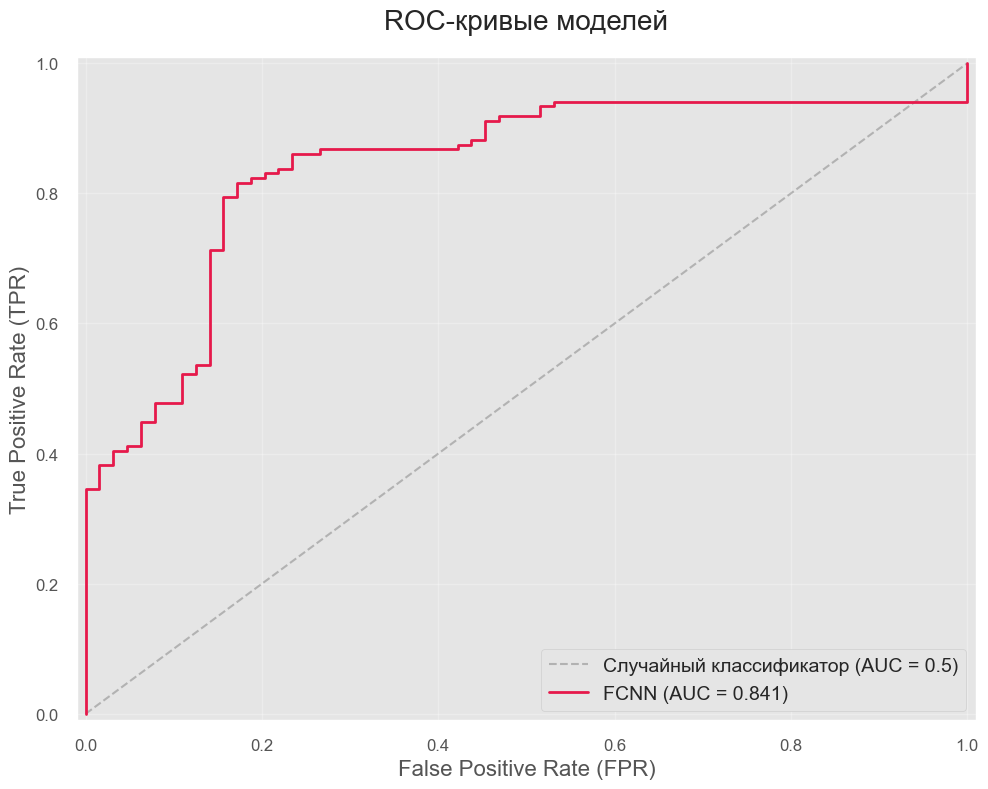

In [158]:
draw_roc_curve(labels, [proba], [preds], ["FCNN"])

In [159]:
preds_all.append(preds)
proba_all.append(proba)
names.append("FCNN")

Обучение CNN

In [144]:
params = {'weight_decay': 0.0001, 'gamma': 4., 'random_seed': 42, 'lr': 0.0001, 'loss': 'focal', 'kernel_sizes': [3, 5], 'in_channels': 1, 'hidden_dims': [32, 64], 'dropout_rate': 0.3, 'activation': 'gelu', 'val_metric': 0.58}


Processed:   0%|          | 0/50 [00:00<?, ?it/s]

Processed: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]

Training complete successfully. Best accuracy on validation: 0.6800


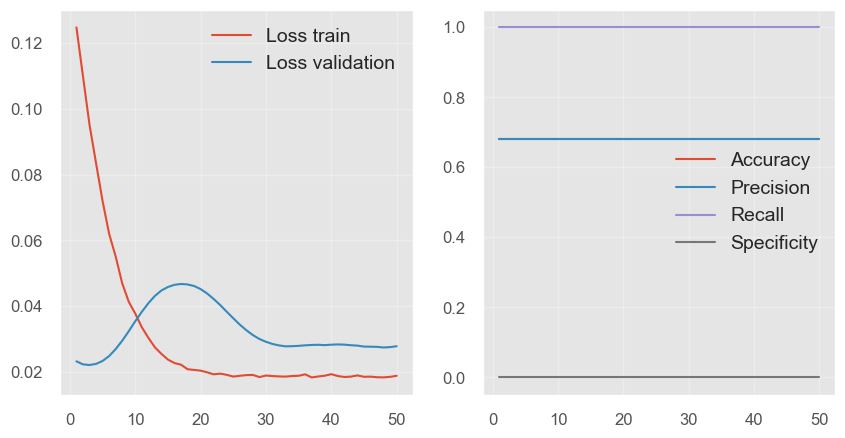

In [146]:
in_dim = len(X_val.columns)

# params = {'weight_decay': 0.0001, 
#           'pos_weight': 0.4716981132075472, 
#           'lr': 0.0005, 
#           'hidden_dims': [128, 64], 
#           'dropout_rate': 0.0, 
#           'activation': 'gelu',}


model = CNN1DSpectrum(
    in_channels=params['in_channels'],
    kernel_sizes=params['kernel_sizes'],
    hidden_dims=params['hidden_dims'],  # Более глубокая архитектура
    activation=params['activation'],  # Можно экспериментировать
    dropout_rate=params['dropout_rate'],
    random_seed=params['random_seed']
)
#model = Discriminator(len(X_val.columns), hidden_dims=[256, 128, 64], out_dim=1, activation="leaky_relu")
# model = CNN1DSpectrum(input_length=in_dim,
#                       in_channels=1,
#                       hidden_dims=[4, 8, 16],
#                       kernel_sizes=[3, 5, 7],
#                       activation="gelu",
#                       dropout_rate=0.3,
#                       use_residual=True)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=params['lr'],  # Уменьшенный LR
    weight_decay=params['weight_decay']  # Меньше регуляризации
)

# Изменяем шедулер
scheduler=None
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=0.97, step_size=1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
weight = len(y_train[y_train==0]) / (len(y_train[y_train==1]))
if params['loss'] == 'focal':
    criterion = FocalLoss(alpha=weight, gamma=params['gamma'])
else:
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

epochs = 50
losses_train, losses_val, acc, precision, recall, specificity = train(model, epochs=epochs, optim=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=val_dataloader, scheduler=scheduler)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, epochs + 1), losses_train)
ax[0].plot(range(1, epochs + 1), losses_val)
ax[0].legend(["Loss train", "Loss validation"])
ax[1].plot(range(1, epochs+1), acc)
ax[1].plot(range(1, epochs+1), precision)
ax[1].plot(range(1, epochs+1), recall)
ax[1].plot(range(1, epochs+1), specificity)
ax[1].legend(["Accuracy", "Precision", "Recall", "Specificity"])

In [160]:
preds, proba, labels = predict(model, val_dataloader)
print_metrics(labels, preds, "FCNN")

FCNN classifier:
Accuracy: 0.68 ± 0.03
Precision: 0.68 ± 0.03
Recall: 1.00 ± 0.00
Specificity: 0.00 ± 0.00
--------------------------------------------------


In [161]:
proba_all.append(proba)
preds_all.append(preds)
names.append("CNN")

In [ ]:
param_distributions = {
    "in_channels": [1],  # Фиксированное значение (1D сигналы)
    "hidden_dims": [
        [32, 64, 128],  # Базовая конфигурация
        [64, 128, 256], # Увеличенная ёмкость
        [16, 32, 64]    # Уменьшенная ёмкость
    ],
    "kernel_sizes": [
        [5, 3, 3],      # Базовая конфигурация
        [7, 5, 3],      # Более крупные ядра в первых слоях
        [3, 3, 3]       # Мелкие ядра
    ],
    "activation": ["gelu", "leaky_relu", "selu"],  # Варианты активаций
    "dropout_rate": [0.1, 0.2, 0.3, 0.4, 0.5],  # Уровень dropout
    "lr": [1e-4, 1e-3, 5e-4],
    "weight_decay": [1e-5, 1e-6, 1e-4],
    "loss": ["focal", "bce"],
    "gamma": [0., 1., 2., 3., 4.],
    "random_seed": [42]
}
model_params = ['hidden_dims', 'activation', 'dropout_rate', 'random_seed']
search = HyperparameterSearch(SpectralClassifierFCNN, param_distributions, model_params_names=model_params, n_iter=100)
search.fit(X_train=X_train_scaled, y_train=y_train_noaug, X_val=X_val_scaled, y_val=y_val, epochs=100, batch_size=256)

# Лучшие параметры
print("Лучшие параметры:", search.results_[0])

100%|██████████| 100/100 [03:49<00:00,  2.29s/it]

Лучшие параметры: {'weight_decay': 0.0001, 'random_seed': 42, 'lr': 0.0005, 'loss': 'focal', 'kernel_sizes': [7, 5, 3], 'in_channels': 1, 'hidden_dims': [32, 64, 128], 'dropout_rate': 0.3, 'activation': 'gelu', 'val_metric': 0.58}


### Трансформер

Processed:   0%|          | 0/50 [00:00<?, ?it/s]

Processed: 100%|██████████| 50/50 [00:07<00:00,  7.13it/s]

Training complete successfully. Best accuracy on validation: 0.6950


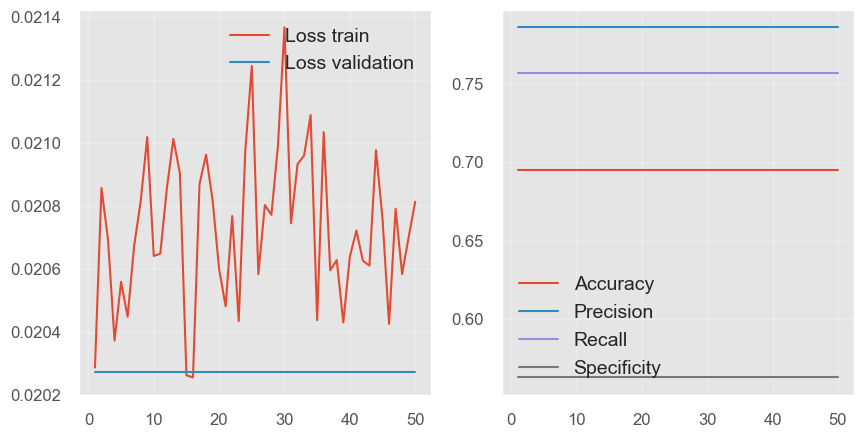

In [151]:
in_dim = len(X_val.columns)

params = {'weight_decay': 0.0001, 'seed': 42, 'patch_size':32, 'num_layers': 4, 'num_heads': 2, 'num_classes': 1, 'lr': 5e-04, 'loss': 'focal', 'hidden_dim': 32, 'dropout': 0.3, 'batch_size': 128, 'val_metric': 0.8220064724919094}

model_trans = SpectralTransformer(
    in_dim=in_dim,
    num_classes=params['num_classes'],
    num_heads=params['num_heads'],
    num_layers=params['num_layers'],
    hidden_dim=params['hidden_dim'],
    patch_size=params['patch_size'],
    dropout=params['dropout'],
    seed=params['seed']
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=params['lr'],  # Уменьшенный LR
    weight_decay=params['weight_decay']  # Меньше регуляризации
)

# Изменяем шедулер
scheduler=None
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=0.97, step_size=1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

weight = len(y_train[y_train==0]) / (len(y_train[y_train==1]))
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
criterion = FocalLoss(alpha=weight, gamma=4.)

epochs = 50
losses_train, losses_val, acc, precision, recall, specificity = train(model_trans, epochs=epochs, optim=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=val_dataloader, scheduler=scheduler)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, epochs + 1), losses_train)
ax[0].plot(range(1, epochs + 1), losses_val)
ax[0].legend(["Loss train", "Loss validation"])
ax[1].plot(range(1, epochs+1), acc)
ax[1].plot(range(1, epochs+1), precision)
ax[1].plot(range(1, epochs+1), recall)
ax[1].plot(range(1, epochs+1), specificity)
ax[1].legend(["Accuracy", "Precision", "Recall", "Specificity"])

In [ ]:
param_distributions = {
    # Архитектурные параметры
    'num_heads': [4, 8],              # Количество голов внимания
    'num_layers': [4, 6, 8],          # Глубина трансформера
    'hidden_dim': [32, 64],    # Размер скрытого представления
    'num_classes': [1],
    'patch_size': [16, 32, 64],       # Размер сегментов спектра
    
    # Регуляризация
    'dropout': [0.1, 0.2, 0.3],       # Уровень дропаута
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-6],     # L2-регуляризация
    
    # Оптимизация
    'lr': [5e-5, 1e-4, 3e-4, 1e-3, 5e-4],         # Скорость обучения
    "loss": ["focal"],
    'seed': [42]
}
model_params = ['num_heads', 'num_layers', 'hidden_dim', 'patch_size', 'dropout', 'patch_size', 'num_classes']
search = HyperparameterSearch(SpectralTransformer, param_distributions, model_params_names=model_params, n_iter=50)
search.fit(X_train=X_train_scaled, y_train=y_train_noaug, X_val=X_val_scaled, y_val=y_val, epochs=100, batch_size=256)

# Лучшие параметры
print("Лучшие параметры:", search.results_[0])

100%|██████████| 50/50 [24:49<00:00, 29.78s/it]

Лучшие параметры: {'weight_decay': 0.0001, 'seed': 42, 'patch_size': 16, 'num_layers': 6, 'num_heads': 8, 'num_classes': 1, 'lr': 5e-05, 'loss': 'focal', 'hidden_dim': 64, 'dropout': 0.3, 'batch_size': 128, 'val_metric': 0.8220064724919094}


In [162]:
preds, proba, labels = predict(model_trans, val_dataloader)
print_metrics(labels, preds, "Table Transformer")

Table Transformer classifier:
Accuracy: 0.69 ± 0.03
Precision: 0.79 ± 0.03
Recall: 0.76 ± 0.04
Specificity: 0.56 ± 0.06
--------------------------------------------------


In [164]:
proba_all.append(proba)
preds_all.append(preds)
names.append("Table Transformer")

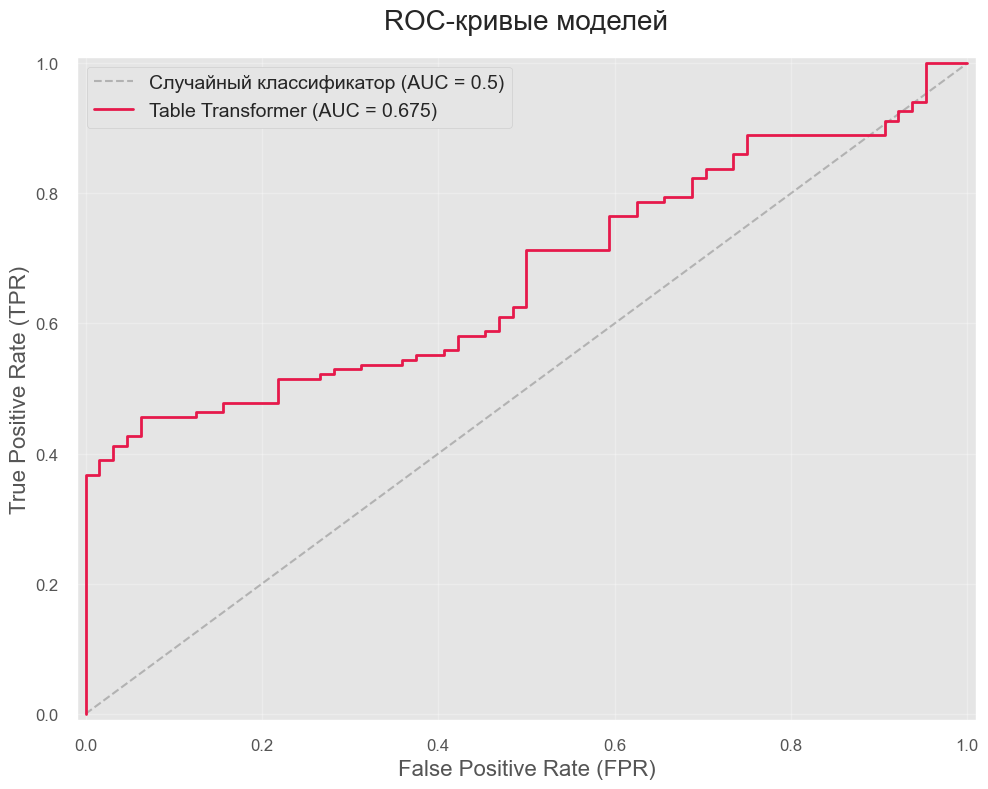

In [154]:
draw_roc_curve(labels, [proba], [preds], ["Table Transformer"])

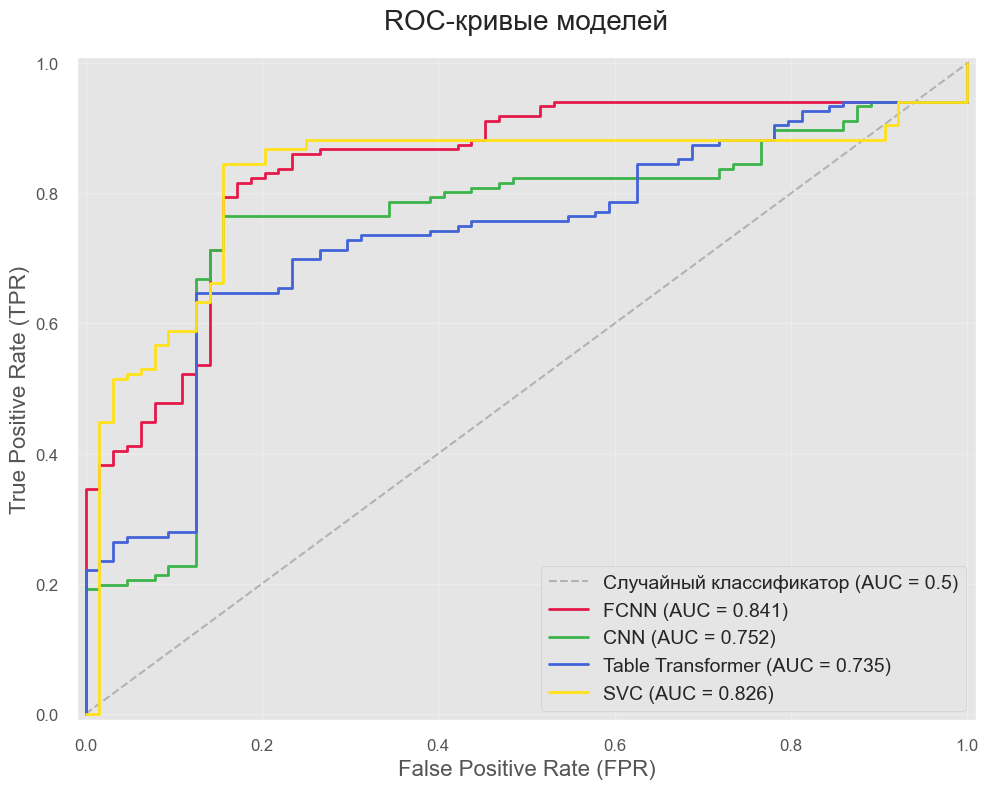

In [168]:
draw_roc_curve(labels, proba_all, preds_all, names)

## Калибровка нейросети

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from matplotlib.lines import Line2D

def plot_calibration_curve(y_true, y_pred_probs, n_bins=10, strategy='uniform', 
                           title='Калибровочная кривая', figsize=(10, 6), 
                           color='#1f77b4', perfect_color='red', 
                           hist_color='skyblue', alpha=0.7):
    """
    Рисует калибровочную кривую и гистограмму распределения вероятностей.
    
    Параметры:
    -----------
    y_true : array-like
        Истинные метки классов (0 или 1).
    y_pred_probs : array-like
        Предсказанные вероятности класса 1.
    n_bins : int, default=10
        Количество бинов для калибровки.
    strategy : {'uniform', 'quantile'}, default='uniform'
        Стратегия бининга ('quantile' для равного числа samples в бинах).
    title : str, default='Калибровочная кривая'
        Заголовок графика.
    figsize : tuple, default=(10, 6)
        Размер фигуры.
    color : str, default='#1f77b4'
        Цвет калибровочной кривой.
    perfect_color : str, default='red'
        Цвет линии идеальной калибровки.
    hist_color : str, default='skyblue'
        Цвет гистограммы.
    alpha : float, default=0.7
        Прозрачность гистограммы.
    """
    
    # Вычисление калибровочной кривой
    prob_true, prob_pred = calibration_curve(
        y_true, y_pred_probs, n_bins=n_bins, strategy=strategy
    )
    
    # Создание фигуры
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    # Калибровочная кривая
    ax1.plot(prob_pred, prob_true, 'o-', label='Модель', color=color, linewidth=2)
    ax1.plot([0, 1], [0, 1], '--', label='Идеальная калибровка', 
             color=perfect_color, linewidth=2)
    
    # Настройки первого subplot
    ax1.set_title(title, fontsize=20, pad=20)
    ax1.set_xlabel('Предсказанная вероятность', fontsize=16)
    ax1.set_ylabel('Истинная вероятность', fontsize=16)
    ax1.legend(loc='upper left', framealpha=1)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Гистограмма распределения вероятностей
    ax2.hist(y_pred_probs, bins=n_bins, range=(0, 1), 
             color=hist_color, alpha=alpha, edgecolor='black')
    ax2.set_xlabel('Предсказанная вероятность', fontsize=16)
    ax2.set_ylabel('Частота', fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # Общие настройки
    plt.tight_layout()
    plt.show()

# Пример использования:
# y_true = np.array([0, 1, 0, 1, 1])
# y_probs = np.array([0.1, 0.4, 0.35, 0.8, 0.9])
# plot_calibration_curve(y_true, y_probs, n_bins=5)

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from matplotlib.lines import Line2D

def plot_calibration_curves(y_true, 
                            y_pred_probs_list, 
                            model_names=None, 
                            n_bins=10, 
                            strategy='uniform', 
                            title='Калибровочные кривые', 
                            figsize=(12, 8),
                            colors=None, 
                            perfect_color='red', 
                            hist_colors=None, 
                            alpha=0.7):
    
    n_models = len(y_pred_probs_list)

    if colors is None:
        colors = plt.cm.tab10(np.linspace(0, 1, n_models))
    
    if hist_colors is None:
        hist_colors = plt.cm.Pastel1(np.linspace(0, 1, n_models))
    
    if model_names is None:
        model_names = [f'Модель {i+1}' for i in range(n_models)]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, 
                                   gridspec_kw={'height_ratios': [3, 1]})
    
    for i, (y_pred_probs, color) in enumerate(zip(y_pred_probs_list, colors)):
        prob_true, prob_pred = calibration_curve(
            y_true, y_pred_probs, n_bins=n_bins, strategy=strategy
        )
        
        ax1.plot(prob_pred, prob_true, 'o-', label=model_names[i], 
                 color=color, linewidth=2, markersize=8)

    ax1.plot([0, 1], [0, 1], '--', label='Идеальная калибровка', 
             color=perfect_color, linewidth=2)
    
    ax1.set_title(title, fontsize=20, pad=20)
    ax1.set_xlabel('Предсказанная вероятность', fontsize=16)
    ax1.set_ylabel('Истинная вероятность', fontsize=16)
    ax1.legend(loc='upper left', framealpha=1, fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    for i, (y_pred_probs, hist_color) in enumerate(zip(y_pred_probs_list, hist_colors)):
        ax2.hist(y_pred_probs, bins=n_bins, range=(0, 1), 
                 color=hist_color, alpha=alpha, edgecolor='black',
                 label=model_names[i])
    
    ax2.set_xlabel('Предсказанная вероятность', fontsize=16)
    ax2.set_ylabel('Частота', fontsize=16)
    ax2.legend(loc='upper left', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

Отрисовка калибровочной кривой для исходной нейросети

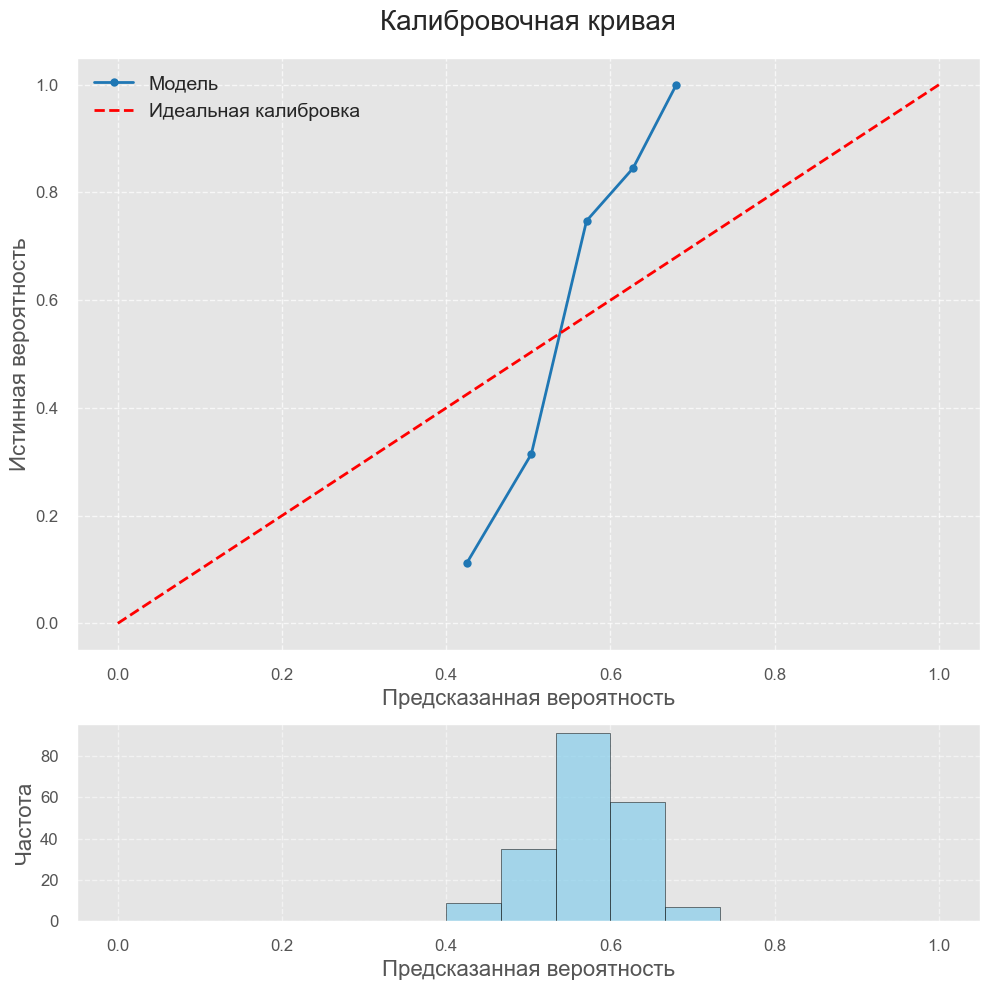

In [190]:
preds, proba, labels = predict(model_fcnn, test_dataloader)
plot_calibration_curve(labels, proba, figsize=(10, 10), n_bins=15)

In [ ]:
import torch
import numpy as np
from sklearn.isotonic import IsotonicRegression
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
class NeuralNetCalibrator:
    def __init__(self, 
                 model, 
                 methods=['isotonic'], 
                 n_bins=15, 
                 fcnn_hidden_size=32, 
                 fcnn_lr=1e-3, 
                 fcnn_epochs=100, 
                 batch_size=64):

        self.model = model
        self.methods = methods
        self.n_bins = n_bins
        self.calibrator = None
        self.fcnn_hidden_size = fcnn_hidden_size
        self.fcnn_lr = fcnn_lr
        self.fcnn_epochs = fcnn_epochs
        self.batch_size = batch_size
        
        self.fcnn_ = None
        
    def fit(self, 
            X_val, 
            y_val,
            batch_size=128):

        val_probs = self._predict_proba(X_val, 
                                        batch_size)
        val_probs = val_probs.cpu().numpy()
        y_val = y_val.cpu().numpy() if \
            isinstance(y_val, torch.Tensor) else y_val
        
        if 'isotonic' in self.methods:
            self.calibrator_iso = IsotonicRegression(
                out_of_bounds='clip'
                )
            self.calibrator_iso.fit(
                val_probs, y_val
                )
            
        if 'platt' in self.methods:

            self.calibrator_platt = LogisticRegression()
            self.calibrator_platt.fit(
                val_probs.reshape(-1, 1), 
                y_val
            )
            
        if 'temperature' in self.methods:
            self.temperature = torch.nn.Parameter(
                torch.ones(1)
                )
            optimizer = torch.optim.AdamW(
                [self.temperature], lr=0.01
                )
        
            def eval():
                optimizer.zero_grad()
                loss = torch.nn.BCELoss()(
                    torch.sigmoid(
                        self._logits(
                            X_val
                        ).squeeze() / self.temperature
                    ),
                    torch.FloatTensor(y_val)
                )
                loss.backward()
                return loss
                
            optimizer.step(eval)
        if 'isotemp' in self.methods:
            self.temperature = torch.nn.Parameter(
                torch.ones(1)
                )
            optimizer = torch.optim.LBFGS(
                [self.temperature], lr=0.01
                )
        
            def eval():
                optimizer.zero_grad()
                loss = torch.nn.BCELoss()(
                    torch.sigmoid(
                        self._logits(
                            X_val
                        ).squeeze() / self.temperature
                    ),
                    torch.FloatTensor(y_val)
                )
                loss.backward()
                return loss
                
            optimizer.step(eval)

            self.calibrator_isotemp = IsotonicRegression(
                out_of_bounds='clip'
                )
            self.calibrator_isotemp.fit(
                torch.sigmoid(
                    self._logits(
                        X_val
                    ).squeeze() / self.temperature
                ).detach().cpu().numpy(), 
                y_val
            )
        
        if 'fcnn' in self.methods:
            val_probs = self._predict_proba(
                X_val, batch_size
                )
            self._train_fcnn(
                val_probs, y_val
                )
    
    def _train_fcnn(self, svc_output, y):
        n_features = svc_output.shape[1] if\
            len(svc_output.shape) > 1 else 1
        
        self.fcnn_ = nn.Sequential(
            nn.Linear(n_features, self.fcnn_hidden_size),
            nn.GELU(),
            nn.Linear(self.fcnn_hidden_size, 1),
        )
        weight = len(y[y == 0]) / len(y[y == 1])
        optimizer = torch.optim.AdamW(
            self.fcnn_.parameters(), lr=self.fcnn_lr
            )
        criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor([weight])
            )
        
        X_tensor = torch.FloatTensor(
            svc_output
            ).unsqueeze(1) if n_features == 1 else\
                  torch.FloatTensor(
                        svc_output
                        )
        y_tensor = torch.FloatTensor(
            (y == 1).astype(np.float32)
            )
        
        dataset = torch.utils.data.TensorDataset(
            X_tensor, y_tensor
            )
        loader = torch.utils.data.DataLoader(
            dataset, 
            batch_size=self.batch_size, 
            shuffle=True
            )
        
        for epoch in range(self.fcnn_epochs):
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                outputs = self.fcnn_(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
    
    def calibrate_proba(self, X, batch_size=128):
        probs = self._predict_proba(
            X, batch_size
            ).cpu().numpy()
        proba_calib = []
        if 'isotonic' in self.methods:
            proba_calib.append(
                self.calibrator_iso.predict(probs)
                )
        if 'platt' in self.methods:
            proba_calib.append(
                self.calibrator_platt.predict_proba(
                    probs.reshape(-1, 1)
                    )[:, 1])
        if 'temperature' in self.methods:
            logits = self._logits(X)
            proba_calib.append(
                torch.sigmoid(
                    logits.squeeze() / self.temperature
                    ).detach().cpu().numpy()
                )
        
        if 'isotemp' in self.methods:
            logits = self._logits(X)
            proba_calib .append(
                self.calibrator_isotemp.predict(
                    torch.sigmoid(
                        logits.squeeze() / self.temperature
                        ).detach().cpu().numpy()
                    )
                )
        
        if 'fcnn' in self.methods:
            logits = self._logits(X)
            proba_raw = torch.sigmoid(logits.squeeze())
            with torch.no_grad():
                svc_tensor = torch.FloatTensor(
                    proba_raw
                    ).unsqueeze(1) if\
                        len(proba_raw.shape) == 1 else\
                        torch.FloatTensor(proba_raw)
                proba_positive = torch.sigmoid(
                    self.fcnn_(svc_tensor).flatten()
                ).numpy()
            
            proba = np.zeros((len(X), 2))
            proba[:, 0] = 1 - proba_positive
            proba[:, 1] = proba_positive
            proba_calib.append(proba_positive)

        if len(proba_calib) > 1:
            proba_mean = proba_calib[0]
            for proba in proba_calib[1:]:
                proba_mean += proba
            return proba / len(proba_calib)
        else:
            return proba_calib[0]
        
    def _predict_proba(self, X, batch_size):

        self.model.eval()
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
            
        dataset = TensorDataset(X)
        loader = DataLoader(dataset, 
                            batch_size=batch_size, 
                            shuffle=False)
        
        probs = []
        with torch.no_grad():
            for batch in loader:
                outputs = self.model(
                    batch[0].to(next(
                        self.model.parameters()
                        ).device)
                    )
                probs.append(torch.sigmoid(outputs))
                
        return torch.cat(probs)
    
    def _logits(self, X):
        self.model.eval()
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
            
        with torch.no_grad():
            logits = self.model(
                X.to(next(
                    self.model.parameters()
                    ).device)
                )
        return logits


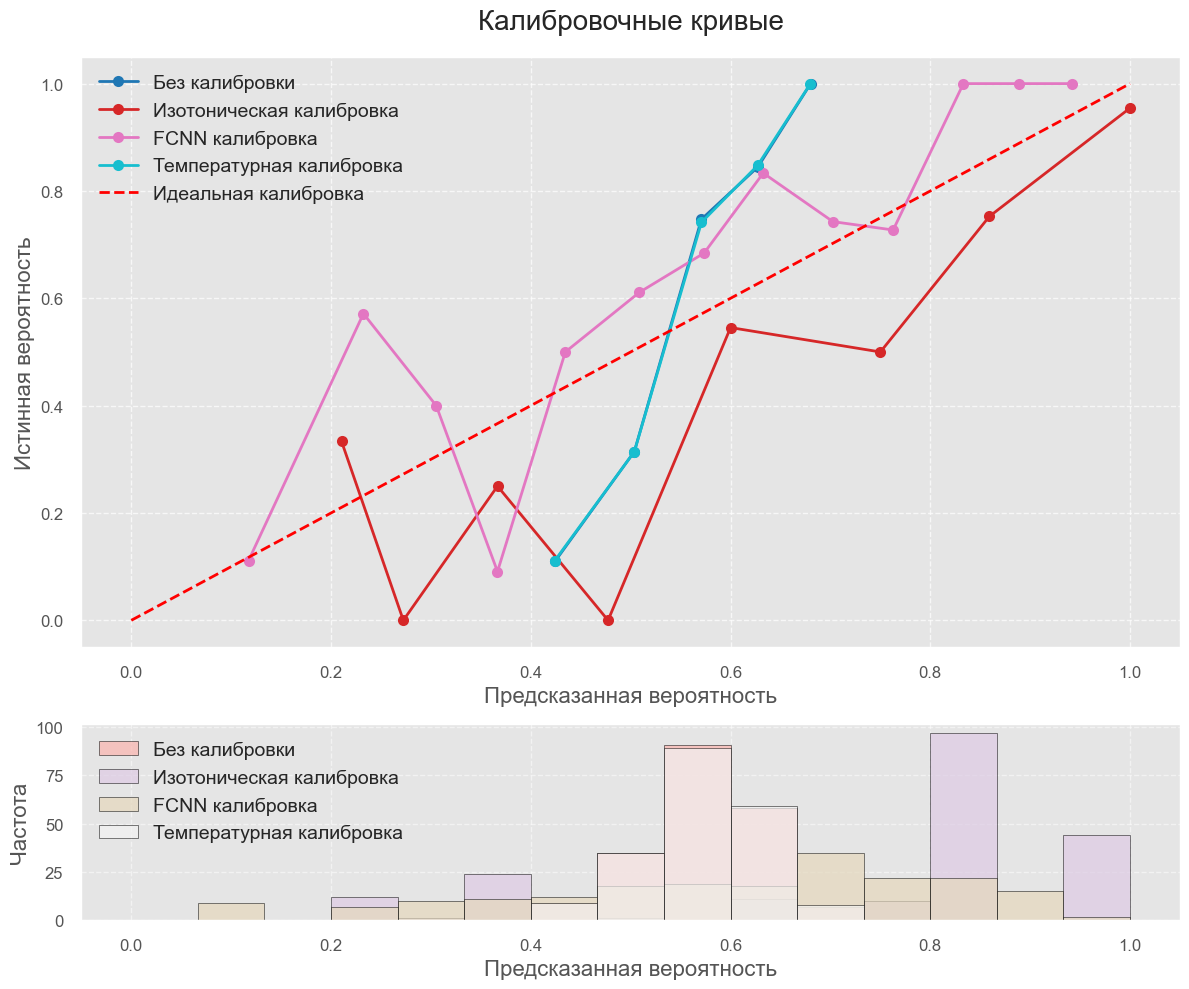

In [191]:
preds, proba, labels = predict(model_fcnn, test_dataloader)
probs_calib = [proba]
names_calib = ["Без калибровки"]
translate = {"isotonic": "Изотоническая", "temperature": "Температурная", "fcnn": "FCNN"}
for method in ["isotonic", "fcnn", "temperature"]:
    calib = NeuralNetCalibrator(model_fcnn, methods=[method], n_bins=10, fcnn_epochs=300, fcnn_hidden_size=128, fcnn_lr=0.003)
    calib.fit(X_val.to_numpy(), y_val.to_numpy(), batch_size=128)
    proba = calib.calibrate_proba(X_test.to_numpy(), batch_size=128)
    probs_calib.append(proba)
    names_calib.append(translate[method] + " калибровка")
plot_calibration_curves(y_test.to_numpy(), probs_calib, names_calib, n_bins=15, figsize=(12, 10))

In [174]:
calib = NeuralNetCalibrator(model_fcnn, methods=['fcnn'], n_bins=25, fcnn_epochs=300, fcnn_hidden_size=128, fcnn_lr=0.003)
calib.fit(X_val.to_numpy(), y_val.to_numpy(), batch_size=128)
proba = calib.calibrate_proba(X_test.to_numpy(), batch_size=128)
print_metrics(y_test.to_numpy(), (proba > 0.5), "")

 classifier:
Accuracy: 0.75 ± 0.03
Precision: 0.81 ± 0.03
Recall: 0.82 ± 0.03
Specificity: 0.59 ± 0.06
--------------------------------------------------


In [ ]:
preds = (proba > 0.45)

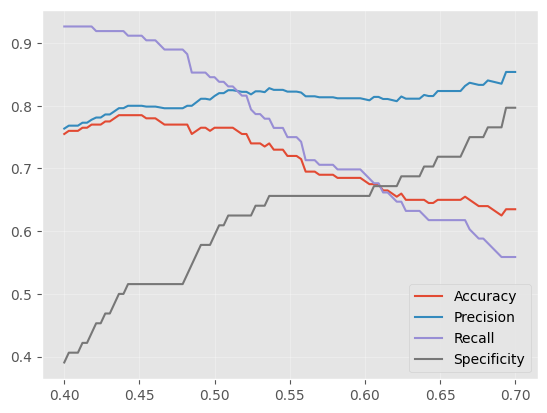

In [ ]:
from sklearn.metrics import confusion_matrix
trhs = np.linspace(0.4, 0.7, 100)
acc = []
prec = []
recall = []
specificity = []
for trh in trhs:
    preds = (proba > trh)
    tn, fp, fn, tp = confusion_matrix(y_test.to_numpy(), preds).ravel()
    acc.append((tp + tn) / (tp + fp + tn + fn))
    prec.append(tp / (tp + fp))
    recall.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

plt.plot(trhs, acc)
plt.plot(trhs, prec)
plt.plot(trhs, recall)
plt.plot(trhs, specificity)
plt.legend(["Accuracy", "Precision", "Recall", "Specificity"])

In [175]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

class SVCToFCNNCalibrator(BaseEstimator, ClassifierMixin):
    def __init__(self, svc_params=None, fcnn_hidden_size=32, 
                 fcnn_lr=0.01, fcnn_epochs=1000, batch_size=64):
        """
        SVC + FCNN калибратор вероятностей
        
        Параметры:
        -----------
        svc_params : dict, optional
            Параметры для SVC (по умолчанию {'kernel':'rbf', 'probability':False})
        fcnn_hidden_size : int, optional
            Размер скрытого слоя FCNN (по умолчанию 32)
        fcnn_lr : float, optional
            Learning rate для FCNN (по умолчанию 0.01)
        fcnn_epochs : int, optional
            Количество эпох обучения FCNN (по умолчанию 1000)
        batch_size : int, optional
            Размер батча для обучения FCNN (по умолчанию 64)
        """
        self.svc_params = svc_params if svc_params else {'kernel':'rbf', 'probability':False}
        self.fcnn_hidden_size = fcnn_hidden_size
        self.fcnn_lr = fcnn_lr
        self.fcnn_epochs = fcnn_epochs
        self.batch_size = batch_size
        
        self.svc_ = None
        self.fcnn_ = None
        self.classes_ = None

    def fit(self, X, y, X_calib=None, y_calib=None):
        """
        Обучение SVC и калибрующей FCNN
        
        Параметры:
        -----------
        X : array-like, shape (n_samples, n_features)
            Обучающие данные для SVC
        y : array-like, shape (n_samples,)
            Целевые значения для SVC
        X_calib : array-like, optional
            Данные для калибровки (если None, используется X)
        y_calib : array-like, optional
            Целевые значения для калибровки (если None, используется y)
        """
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        
        # 1. Обучаем SVC
        self.svc_ = SVC(**self.svc_params)
        self.svc_.fit(X, y)
        
        # 2. Получаем решения SVC для калибровочного набора
        if X_calib is None:
            X_calib, y_calib = X, y
        else:
            X_calib, y_calib = check_X_y(X_calib, y_calib)
            
        svc_output = self.svc_.decision_function(X_calib)
        
        # 3. Обучаем FCNN для калибровки
        self._train_fcnn(svc_output, y_calib)
        
        return self

    def _train_fcnn(self, svc_output, y):
        """Обучение калибрующей FCNN"""
        n_features = svc_output.shape[1] if len(svc_output.shape) > 1 else 1
        
        self.fcnn_ = nn.Sequential(
            nn.Linear(n_features, self.fcnn_hidden_size),
            nn.GELU(),
            nn.Linear(self.fcnn_hidden_size, 1),
        )
        weight = len(y[y == 0]) / len(y[y == 1])
        optimizer = torch.optim.Adam(self.fcnn_.parameters(), lr=self.fcnn_lr)
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        X_tensor = torch.FloatTensor(svc_output).unsqueeze(1) if n_features == 1 else torch.FloatTensor(svc_output)
        y_tensor = torch.FloatTensor((y == self.classes_[1]).astype(np.float32))
        
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        for epoch in range(self.fcnn_epochs):
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                outputs = self.fcnn_(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

    def predict_proba(self, X):
        """Предсказание вероятностей"""
        check_array(X)
        with torch.no_grad():
            svc_output = self.svc_.decision_function(X)
            svc_tensor = torch.FloatTensor(svc_output).unsqueeze(1) if len(svc_output.shape) == 1 else torch.FloatTensor(svc_output)
            proba_positive = torch.sigmoid(self.fcnn_(svc_tensor).flatten()).numpy()
            
        proba = np.zeros((len(X), 2))
        proba[:, 0] = 1 - proba_positive
        proba[:, 1] = proba_positive
        return proba

    def predict(self, X):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        return self.classes_[(proba[:, 1] > 0.5).astype(int)]


calibrator = SVCToFCNNCalibrator(
    svc_params={'kernel':'poly', 'C':10.0, 'gamma': 'scale', 'random_state': 42, 'class_weight':"balanced", 'probability':True, 'tol': 0.001},
    fcnn_hidden_size=64,
    fcnn_lr=0.0005,
    fcnn_epochs=200
)
calibrator.fit(X_train_noaug, y_train_noaug, X_val, y_val)

SVCToFCNNCalibrator(fcnn_epochs=200, fcnn_hidden_size=64, fcnn_lr=0.0005,
                    svc_params={'C': 10.0, 'class_weight': 'balanced',
                                'gamma': 'scale', 'kernel': 'poly',
                                'probability': True, 'random_state': 42,
                                'tol': 0.001})

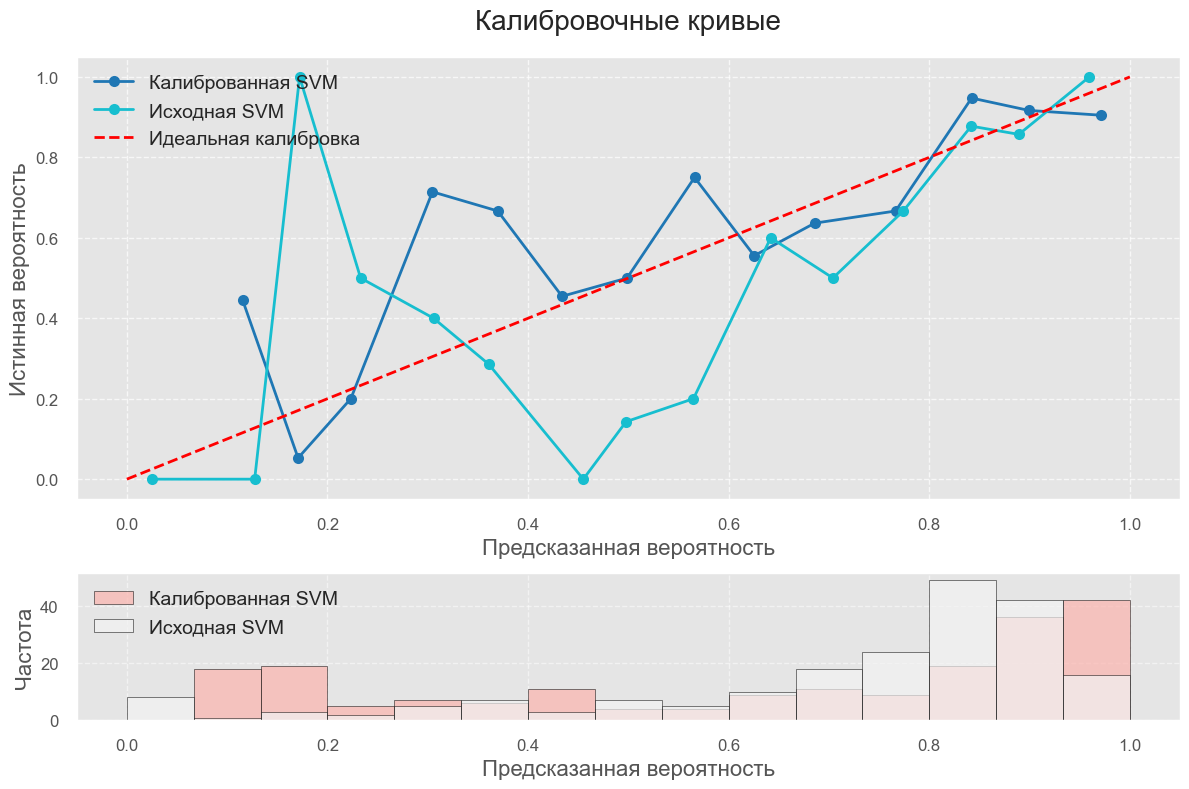

In [192]:
proba = calibrator.predict_proba(X_test.to_numpy())[:, 1]
svc_proba = clf_svc.predict_proba(X_test)[:, 1]
plot_calibration_curves(y_test.to_numpy(), [proba, svc_proba], ["Калиброванная SVM", "Исходная SVM"], n_bins=15)

In [ ]:
preds, proba, labels = model_fcnn.predict(test_dataloader)
print_metrics(y_test.to_numpy(), preds, '')

 classifier:
Accuracy: 0.73
Precision: 0.74
Recall: 0.93
Specificity: 0.30
--------------------------------------------------


In [ ]:
print_metrics(y_test.to_numpy(), calibrator.predict(X_test.to_numpy()), '')

 classifier:
Accuracy: 0.78
Precision: 0.84
Recall: 0.82
Specificity: 0.67
--------------------------------------------------


In [ ]:
preds_svc = clf_svc.predict(X_test)
print_metrics(y_test.to_numpy(), preds_svc, "")

 classifier:
Accuracy: 0.77
Precision: 0.80
Recall: 0.88
Specificity: 0.53
--------------------------------------------------


In [177]:
preds_svc = calibrator.predict(X_test.to_numpy())
proba_fcnn = calib.calibrate_proba(X_test.to_numpy(), batch_size=64)
preds_fcnn = (proba_fcnn > 0.5).astype(int)
print_metrics(y_test.to_numpy(), preds_svc, "SVC")
print_metrics(y_test.to_numpy(), preds_fcnn, "FCNN")
proba_fcnn = calib.calibrate_proba(X_test.to_numpy(), batch_size=64)
proba_svc = calibrator.predict_proba(X_test.to_numpy())[:, 1]
mean_proba = (0.5*proba_fcnn + 0.5*proba_svc) 
preds = (mean_proba >= 0.5).astype(int)
print_metrics(y_test.to_numpy(), preds, "Conbined")

SVC classifier:
Accuracy: 0.78 ± 0.03
Precision: 0.85 ± 0.03
Recall: 0.82 ± 0.03
Specificity: 0.69 ± 0.06
--------------------------------------------------
FCNN classifier:
Accuracy: 0.75 ± 0.03
Precision: 0.81 ± 0.03
Recall: 0.82 ± 0.03
Specificity: 0.59 ± 0.07
--------------------------------------------------
Conbined classifier:
Accuracy: 0.76 ± 0.03
Precision: 0.84 ± 0.03
Recall: 0.80 ± 0.03
Specificity: 0.67 ± 0.06
--------------------------------------------------


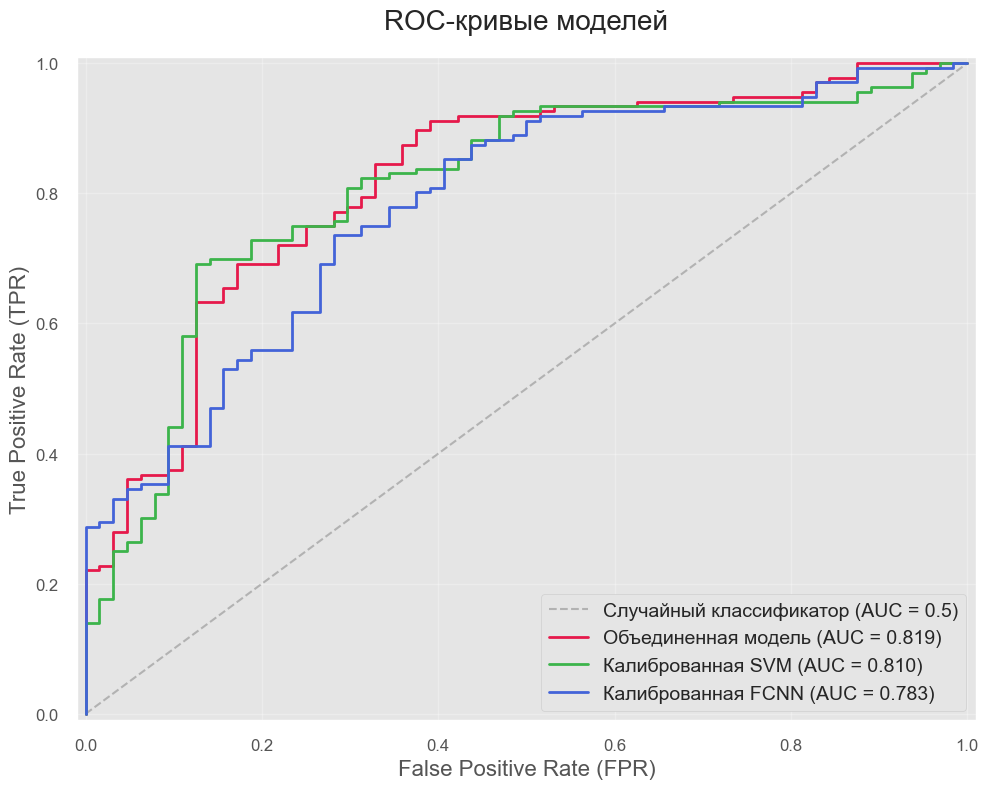

In [178]:
draw_roc_curve(labels, [mean_proba, proba_svc, proba_fcnn], [preds, preds_svc, preds_fcnn], ["Объединенная модель", "Калиброванная SVM", "Калиброванная FCNN"])

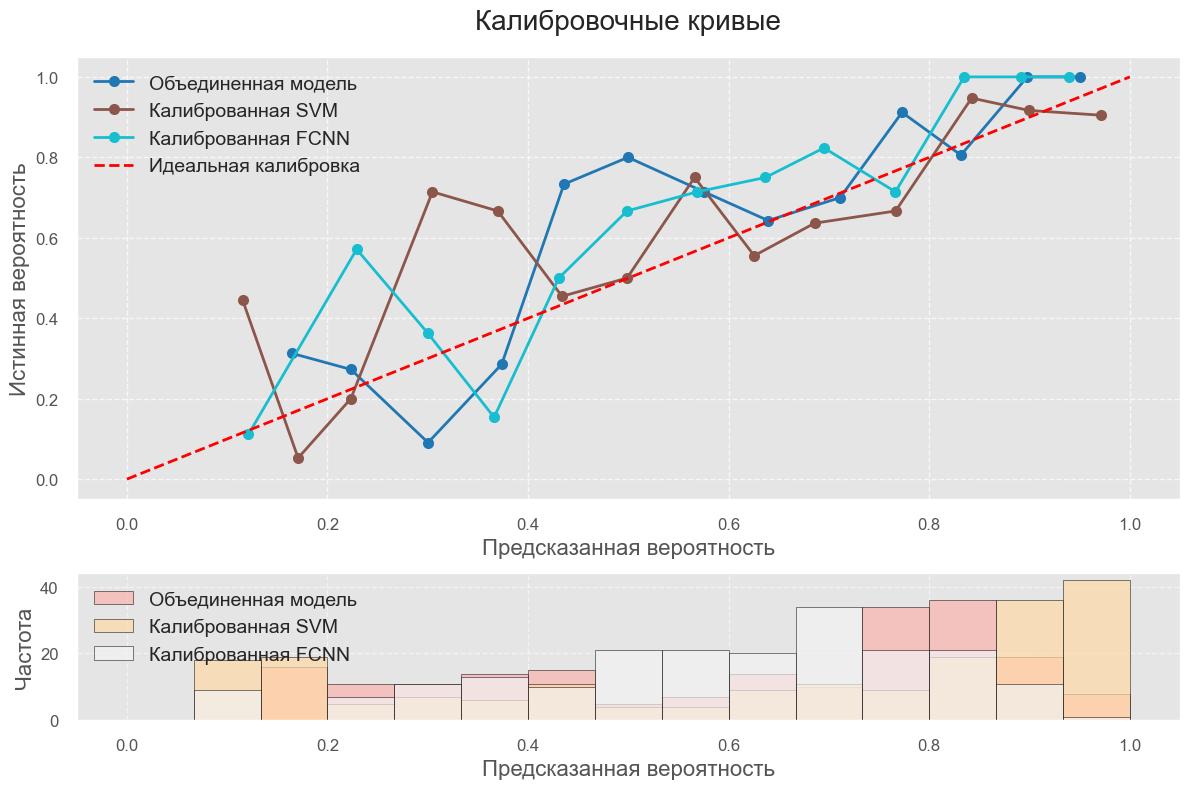

In [193]:
plot_calibration_curves(y_test.to_numpy(), [mean_proba, proba_svc, proba_fcnn], ["Объединенная модель", "Калиброванная SVM", "Калиброванная FCNN"], n_bins=15)

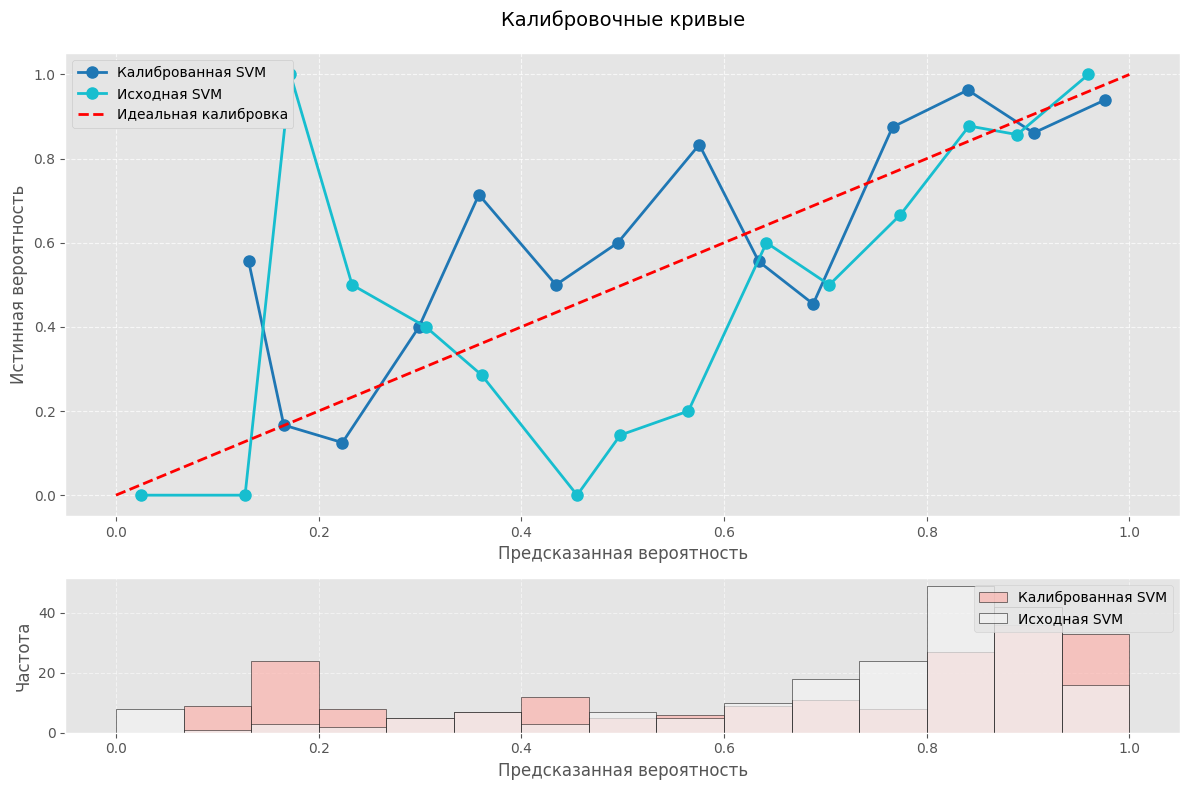

In [ ]:
proba = calibrator.predict_proba(X_test.to_numpy())[:, 1]
svc_proba = clf_svc.predict_proba(X_test)[:, 1]
plot_calibration_curves(y_test.to_numpy(), [proba, svc_proba], ["Калиброванная SVM", "Исходная SVM"], n_bins=15)

In [ ]:
from sklearn.metrics import brier_score_loss
print("Brier Score:", brier_score_loss(y_test.to_numpy(), proba_fcnn))
print("Brier Score:", brier_score_loss(y_test.to_numpy(), proba_svc))
print("Brier Score:", brier_score_loss(y_test.to_numpy(), mean_proba))

Brier Score: 0.17065658791993912
Brier Score: 0.15830277377390142
Brier Score: 0.15710672176984475
